# Modify surface data map

### <div class="alert alert-danger"> Open challenge: fix estremes in curve_fit and polyfit </div>

In [36]:
# mask the one beneath 60 degrees
# dominant vegetation -> fix natpft=12
# resolution of LPJ GUESS
# set titles and axis, title of the legend
# set caracter bigger
# bare ground? it dipends on the ice retrieve
# polynomial workes for longitute? --> just tress btw
#metti lat in vert
# linea sul massimo emostra shift insieme a prec
# mwtti a posto natpdf domnant, no PCT_ etc
# perch esolo range 40-80?

In [37]:
# BOREAL NAT PDFs:
# - 2: NET Boreal
# - 3: NDT Boreal
# - 8: BDT Boreal
# - 11: BDS Boreal
# - 12: artic C3 grass
# - 13: C3 grass
# - 14: C4 grass
#Others:
# - 0: Bare Ground
# - 1: NET Temperate
# - 4: BET Tropical
# - 5: BET Temperate
# - 6: BDT Tropical
# - 7: BDT Temperate
# - 10: BDS Temperate

In [38]:
import numpy as np
import netCDF4 as nc
import xarray as xr
xr.set_options(display_style='html')
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import proplot as pplt

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from owslib.wms import WebMapService
import os
import math

## <div class="alert alert-success">Import and prepare the dataset</div>

In [39]:
# Import surface data file: 
fn='data_out/'
boreal_pfts= xr.open_dataset(fn+'boreal_pfts.nc')
boreal_pfts = boreal_pfts.PCT_NAT_PFT
#boreal_pfts.plot(col='natpft', col_wrap=3); plt.show()
bpfts = list(boreal_pfts.natpft.values)
lnd_frac = xr.open_dataset(fn+'lnd_frac.nc')
lnd_frac = lnd_frac.LANDFRAC_PFT

##  <span style="color:red"> Initial note: starting dataset </span>
<span style="color:red"> The starting dataset is the output of the other Jup and it is refered to `boreal_pfts()`. 
    
This means that:</span>
- <span style="color:red">**0 land** without that PFT and **NaN the ocean**</span>
- <span style="color:red">all the dataset is cut over the `boreal_lat=40`</span>

**This will affect of course the mean over latitude and longitude**

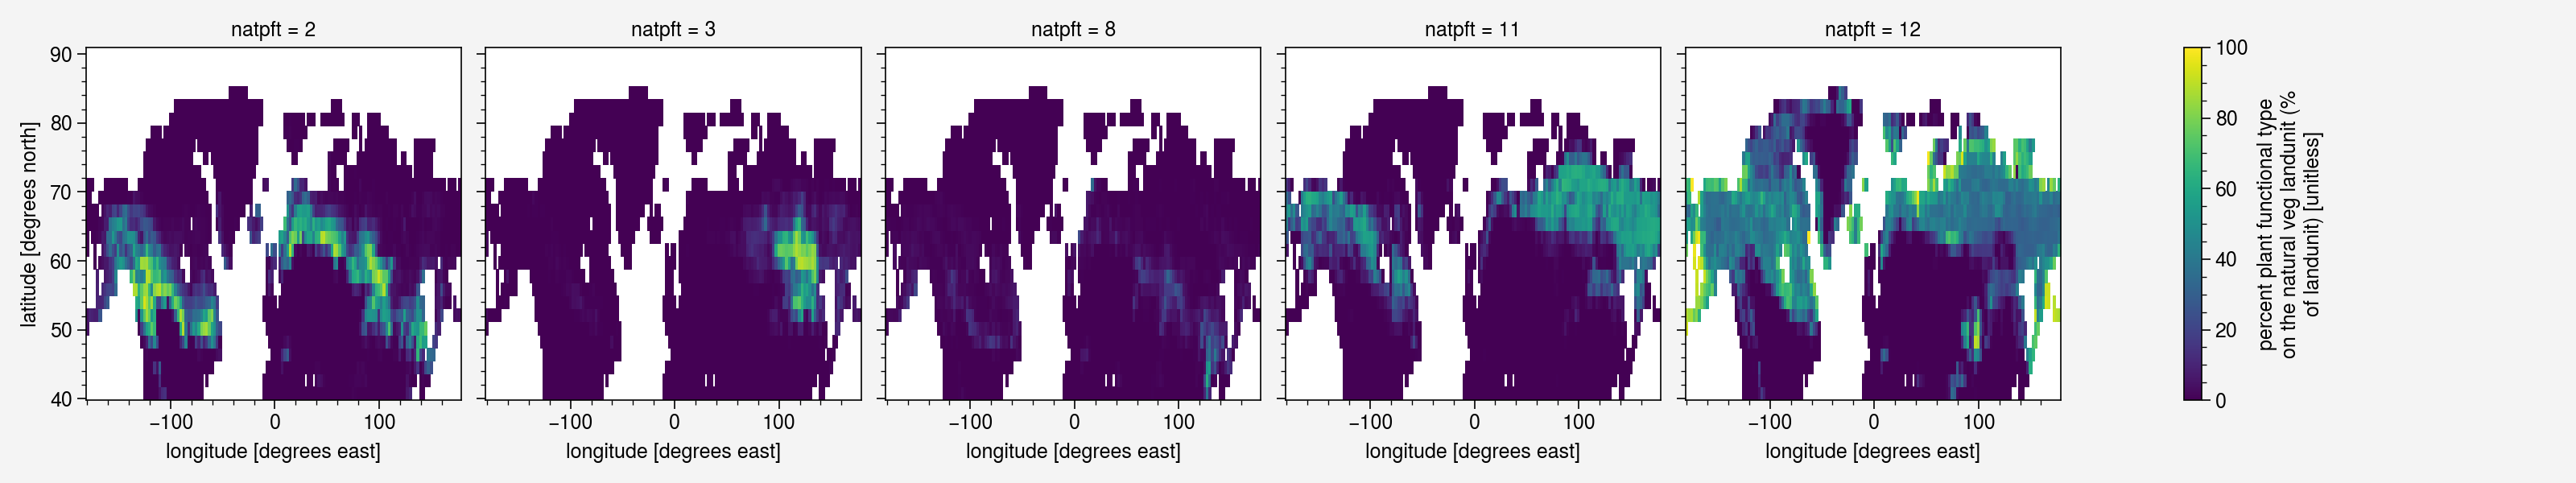

In [40]:
boreal_pfts.plot(col='natpft'); plt.show()

## <div class="alert alert-success">Modify the PFTs configuration</div>

## Idea 
1. For each PFT I find:
- a **function on latitude**: in order to apply the shift 

<span style="color:purple"> **PROBLEM** shrubs at 90° can be substituted by trees with a percentage of 20% as they were shrubs at 60° (less likely to happen at 90° than at 60°)</span>

- a **function on longitude**:this is why there is not just one kind of trees so this can be proxy *--->? by mean? or sum then normalise, or max....*

<span style="color:purple"> **PROBLEM** There are different kinds of trees</span>


Then I create bar plots for each lat and lon I have like 20% of BET, 10% of BDT... (natpft colors)

2. apply the **latitude shift**.

This is a "mask" to ...

3. **Replacement**: apply then in the close relation trees -> shrubs, shrubs -> grass, grass -> bg?

Ex: in cell 20% shrubs at 60° now, then it will be that 20% of shrubs substitute by 30% (30 of 20%) of BET (30% data by "mask")
Note: if the mask says 30%, it's the direct percentage of PFT in the "lower" cell, but it can be tuned so it is normalize to 100% let's say.

**? include also temperate that substite boreal trees?**

# 1. Function of latitude

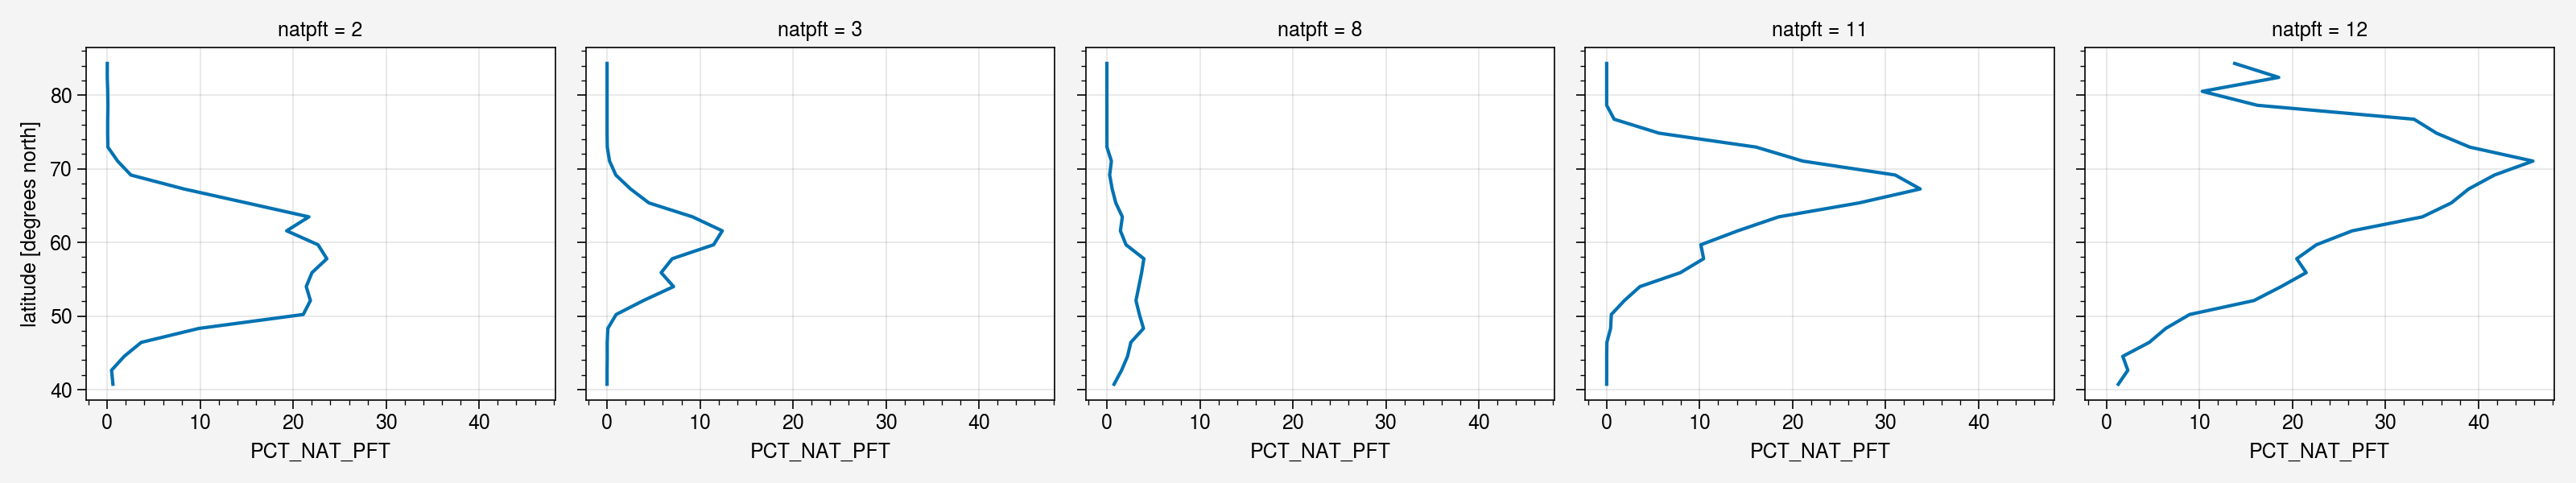

In [41]:
#### Check that land 0, ocean Nan
boreal_pfts = boreal_pfts.where(lnd_frac>0.)
#boreal_pfts.plot(col='natpft')
#boreal_pfts.mean('lon').plot(y='lat', cmap='Greens'); plt.tight_layout(); plt.show()
boreal_pfts.mean('lon').plot(y='lat', col='natpft'); plt.tight_layout(); plt.show()

## 1a. Function of latitude - polynomial and gaussian fit

**Polynomial fit**: *[I filter over lat >10 deg, outside the boreal zone
**OBS!** 'dropna' and 'fillna' are very important to render well the fitting in the target lat range - outside the range the polynomial gives wierd shapes.
But 'dropna' needs to be specify how=all, because otherwise extra rows are dropped, if there is just 1! NaN values!]* --> this was important before having already imported the datset over lat > 40

**Gaussian fit**: better to render presence probability of the PFTs
**OBS**: the fitting didn't work without 'p0' (guessed parameters)

In [42]:
#ds_lat = ds_lat.where(ds_lat.lat> 40.).dropna('lat', how='all').fillna(0.)

In [43]:
def polynomial_fit(ds, dim, deg=3):
    out = ds.polyfit(dim=dim, deg=deg, full=True)
    polyfit = xr.polyval(coord=ds[dim], coeffs=out.polyfit_coefficients).rename('polyfit')
    return polyfit

def gaussian_fit(ds, dim):#, fixed_extremes=True):
    def gaussian(x, A, xc, sig):
        return A*np.exp(-np.power((x - xc),2.) / (2 * np.power(sig,2.)))
    
    #if fixed_extremes==True:
        #sigma = np.ones(len(da[dim].values))
        #sigma[[0, -1]] = 0.01
    fit_params=ds.curvefit(coords=dim, func=gaussian, p0={'A':45, 'xc':55, 'sig':5})#, sigma=sigma)
    popt=fit_params.curvefit_coefficients # NO! .values
    gaussfit = gaussian(ds[dim], *popt.T).drop('param').rename('gaussfit')
    return gaussfit


ds = boreal_pfts.copy()
ds_lat=ds.mean('lon').fillna(0.)#.dropna('lat', how='all')
# Problems with polyfit in dealing with NaN values

polyfit = polynomial_fit(ds = ds_lat, dim='lat', deg = 3)
gaussfit = gaussian_fit(ds = ds_lat, dim='lat')

#polyfit.plot(y='lat', col='natpft', col_wrap=3); plt.suptitle("Polynomial fit"); plt.tight_layout(); plt.show()
#gaussfit.plot(y='lat',col='natpft', col_wrap=3); plt.suptitle("Gaussian fit"); plt.tight_layout(); plt.show()

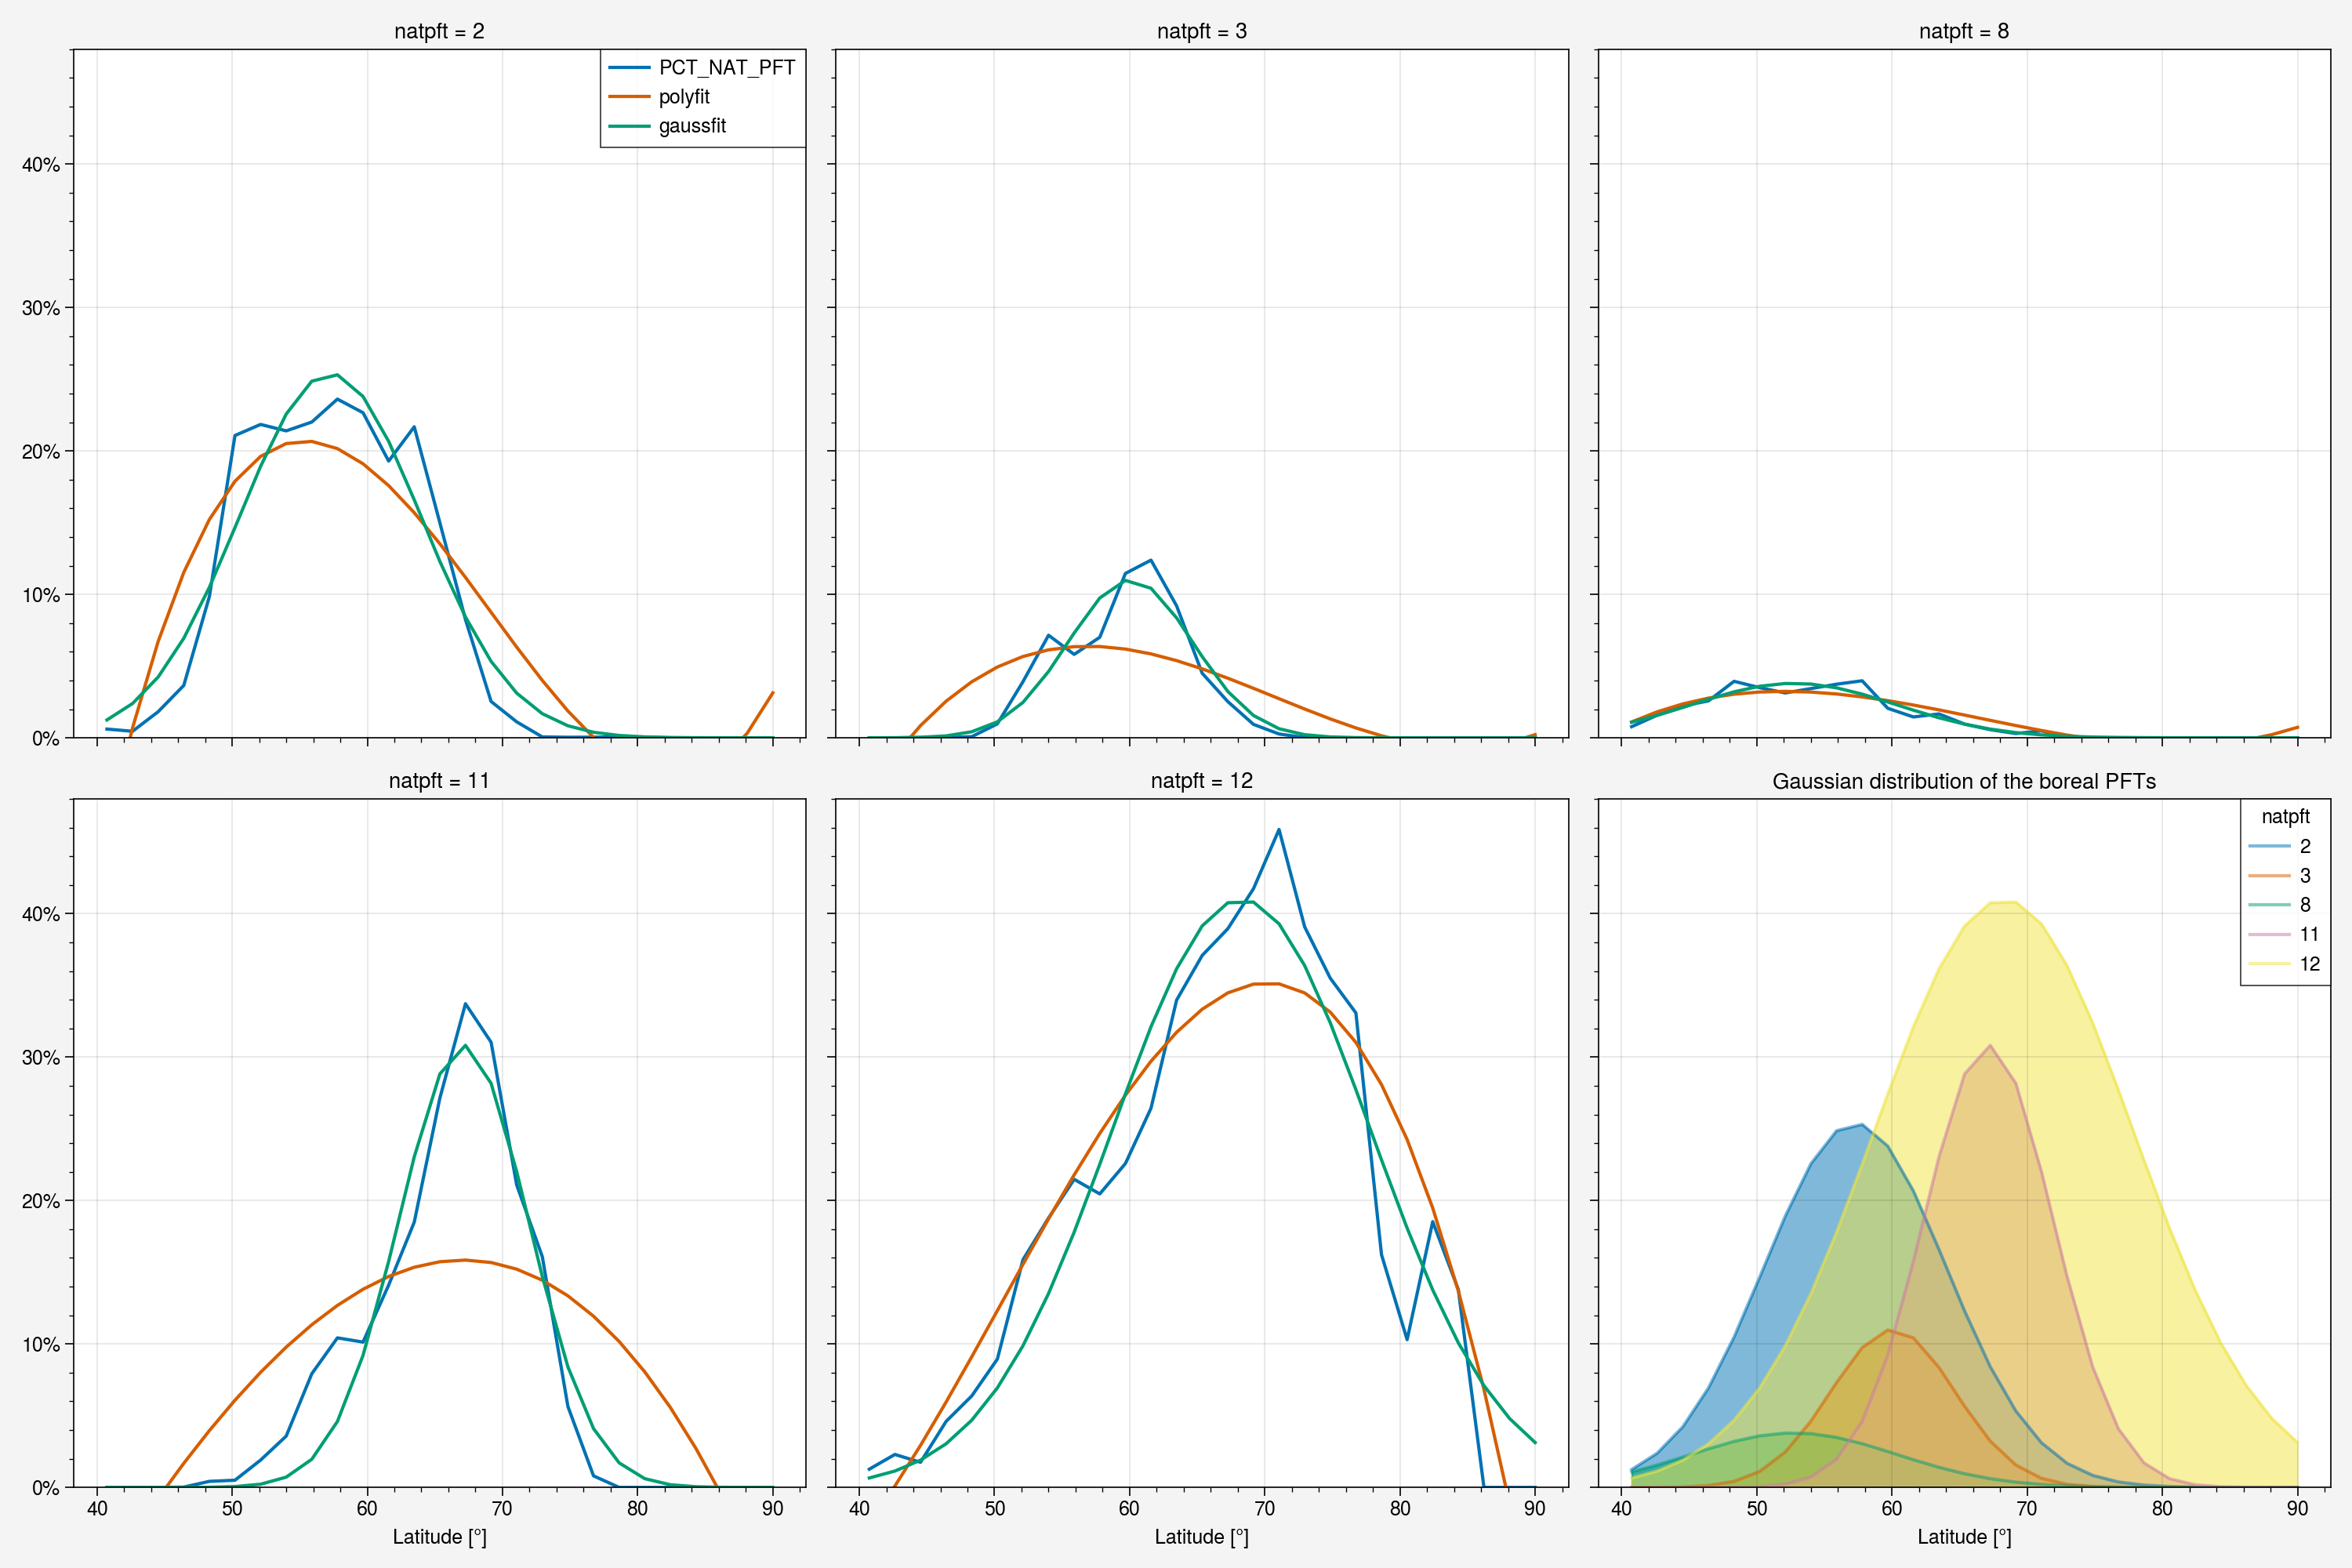

In [44]:
ds_lat = xr.merge([ds_lat, polyfit.T, gaussfit.T])

lines = ['PCT_NAT_PFT','polyfit','gaussfit']

fig, axes = plt.subplots(2, 3, figsize=[15,10], sharex=True, sharey=True)

for b, ax in enumerate(axes.flat):
    if b == 5:
        series = ds_lat['gaussfit'].rename('').to_series().unstack()
        series.plot.area(ax=ax, stacked=False)
        ax.legend(bpfts, title='natpft')
        ax.set_xlabel('Latitude [°]')
        ax.set_title("Gaussian distribution of the boreal PFTs")
    else:
        for l in lines:
            ax.plot(ds_lat.lat, ds_lat.isel(natpft= b)[l], label=l)
            ax.set_ylim(0,48)
            ax.set_yticklabels(['{0:g}%'.format(x) for x in ax.get_yticks()])
            ax.set_title('natpft = '+str(bpfts[b]))
            if b==3 or b==4:
                ax.set_xlabel('Latitude [°]')
            if b==0:
                ax.legend()

plt.tight_layout()
plt.show()

The polyfit is not appropriate, also theoretically speaking, we are looking for a **latitude** probability distribution as a "bell" shape: with a peak and desending curves on the side.

Different is the point of the **longitude** where I need to see the avarage distribution in relation to longitude (e.g. related to land/ocean presence) --> polyfit is simple but we are aiming to make a simple model.

### 15 - Boreal trees
Let's gather trees --> new `natpft=15` represents Boreal Trees **[2 - BoNET, 3 – BoNDT, 8 - BoBDT]**

In [45]:
ds = boreal_pfts.copy()
da = boreal_pfts.isel(natpft=[0,1,2]).sum('natpft')
da = da.where(lnd_frac>0.).assign_coords({"natpft":15}).expand_dims('natpft')
boreal_pfts_macro = xr.concat((da, ds), dim='natpft').sel(natpft=[15,11,12])

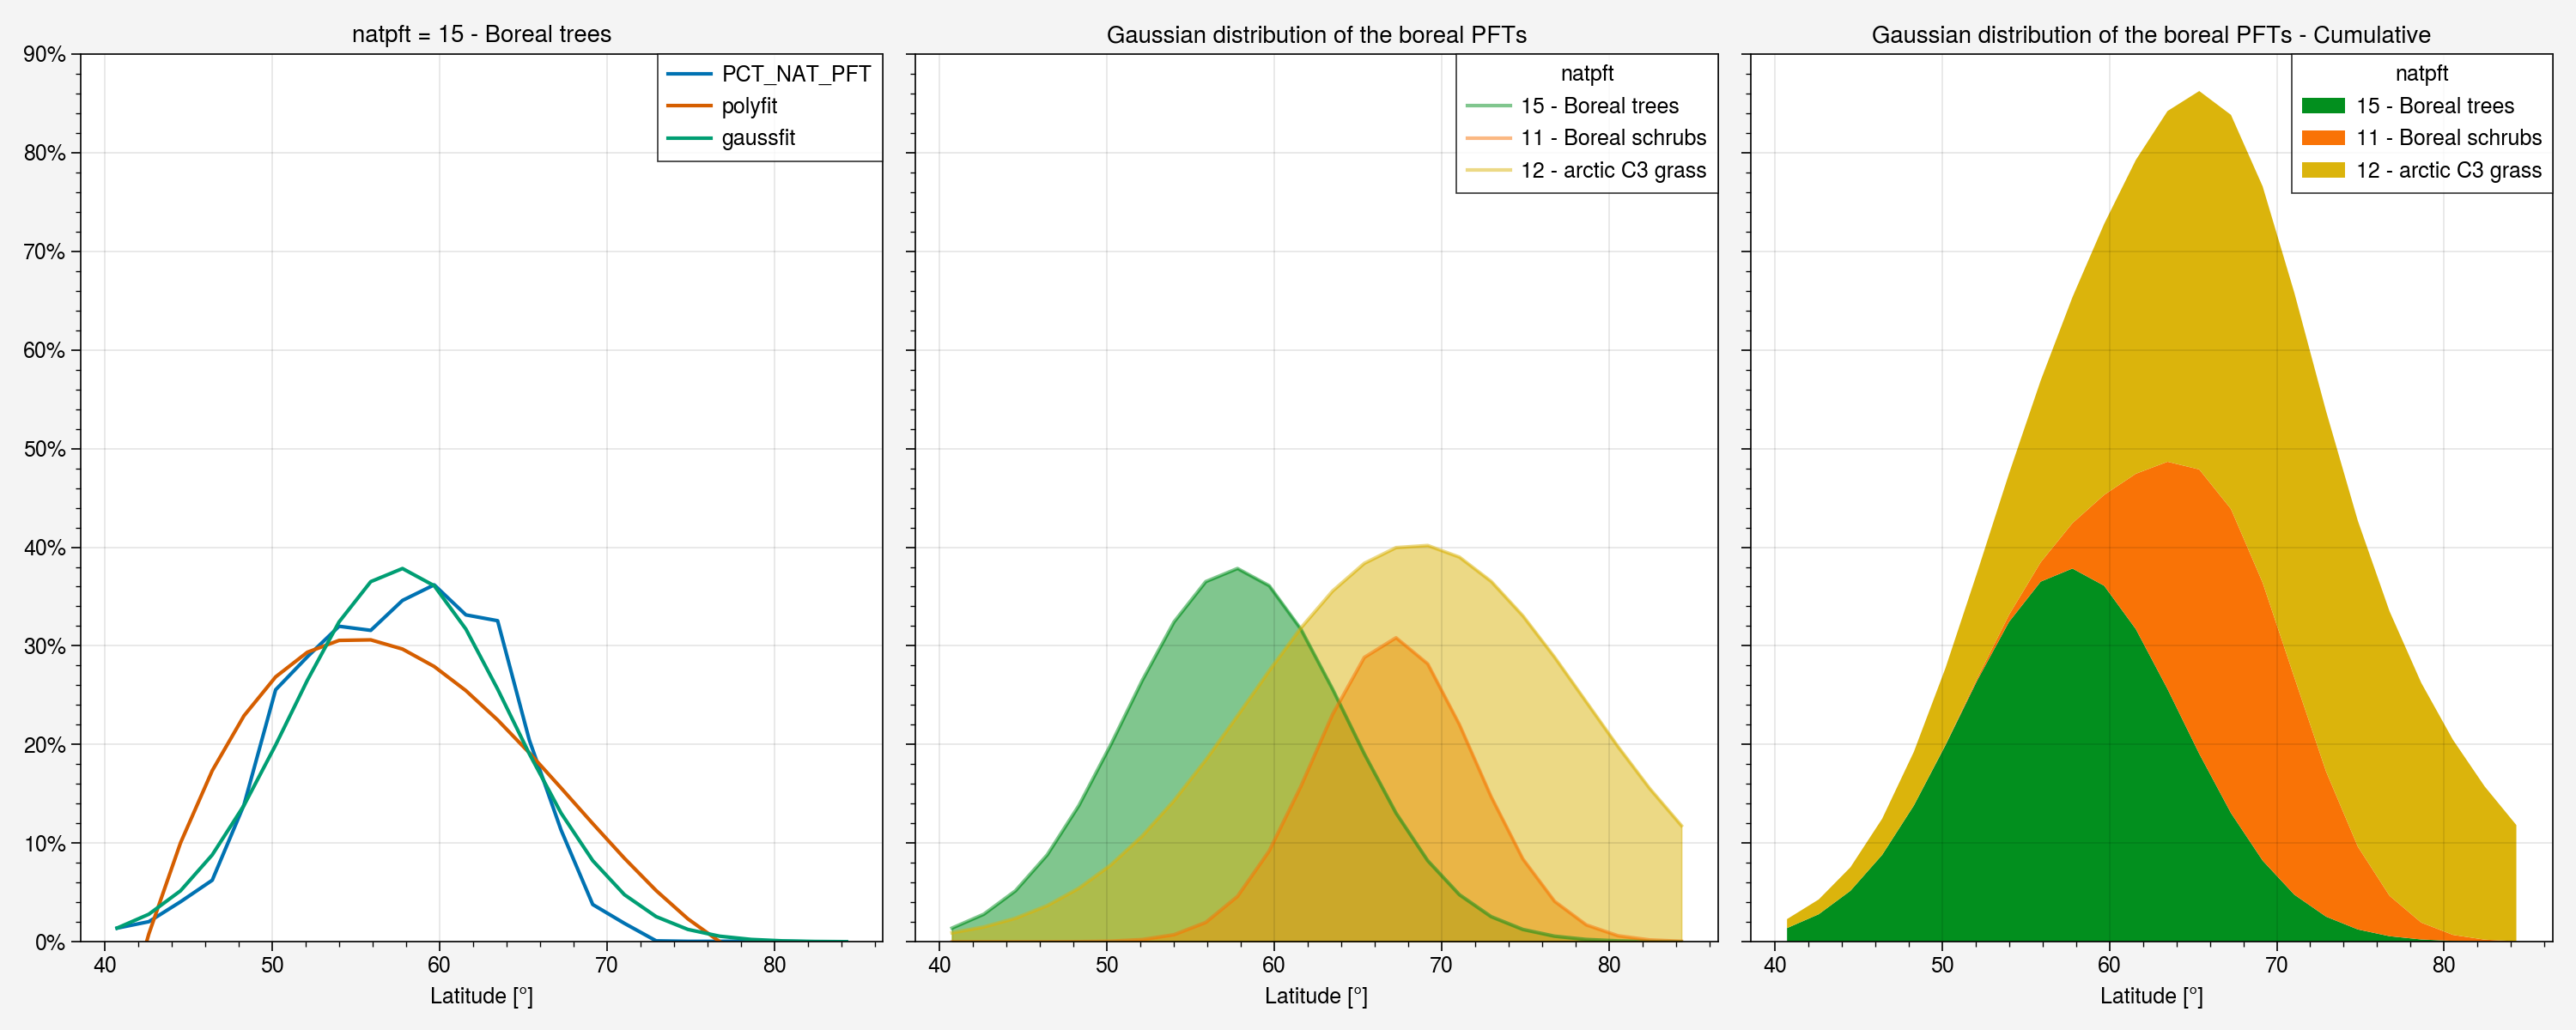

In [46]:
ds_lat_m=boreal_pfts_macro.dropna('lat', how='all').mean('lon')
# Problems with polyfit in dealing with NaN values

polyfit_m = polynomial_fit(ds = ds_lat_m, dim='lat', deg = 3)
gaussfit_m = gaussian_fit(ds = ds_lat_m, dim='lat')

#ds_lat_m.plot(y='lat', col='natpft'); plt.suptitle("Raw data"); plt.tight_layout(); plt.show()
#polyfit_m.plot(y='lat', col='natpft'); plt.suptitle("Polynomial fit"); plt.tight_layout(); plt.show()
#gaussfit_m.plot(y='lat',col='natpft'); plt.suptitle("Gaussian fit"); plt.tight_layout(); plt.show()

ds_lat_m = xr.merge([ds_lat_m, polyfit_m.T, gaussfit_m.T])
lines = ['PCT_NAT_PFT','polyfit','gaussfit']
colors = ['emerald green', 'orange', 'gold']
legend = ['15 - Boreal trees', '11 - Boreal schrubs', '12 - arctic C3 grass']

fig, axes = plt.subplots(1, 3, figsize=[15,6], sharex=True, sharey=True)

for b, ax in enumerate(axes.flat):
    if b == 0:
        for l in lines:
            ax.plot(ds_lat_m.lat, ds_lat_m.sel(natpft=15)[l], label=l)
            ax.set_ylim(0,90)
            ax.set_title('natpft = 15 - Boreal trees')
            ax.legend()
    elif b == 1:
        series = ds_lat_m['gaussfit'].rename('').to_series().unstack()
        series.plot.area(ax=ax, stacked=False, color=colors)
        ax.legend(legend, title='natpft')
        ax.set_title("Gaussian distribution of the boreal PFTs")
    else:
        ax.stackplot(ds_lat_m.lat, ds_lat_m.gaussfit.T, colors=colors)
        ax.legend(legend, title='natpft')
        ax.set_title("Gaussian distribution of the boreal PFTs - Cumulative")
    ax.set_yticklabels(['{0:g}%'.format(x) for x in ax.get_yticks()])
    ax.set_xlabel('Latitude [°]')

plt.tight_layout()
plt.show()

# 3. Apply the shift on latitude

This will be the dataset with the percentage to apply in the substitution.
**Set the latitude shift to tune the percentage.**

Note: There was a "hole" after lat=84.5 due to the fact that above that lat there is no land, but the gaussian was trunked so I filled the NaN values with 0 so that could be modelled also that part.

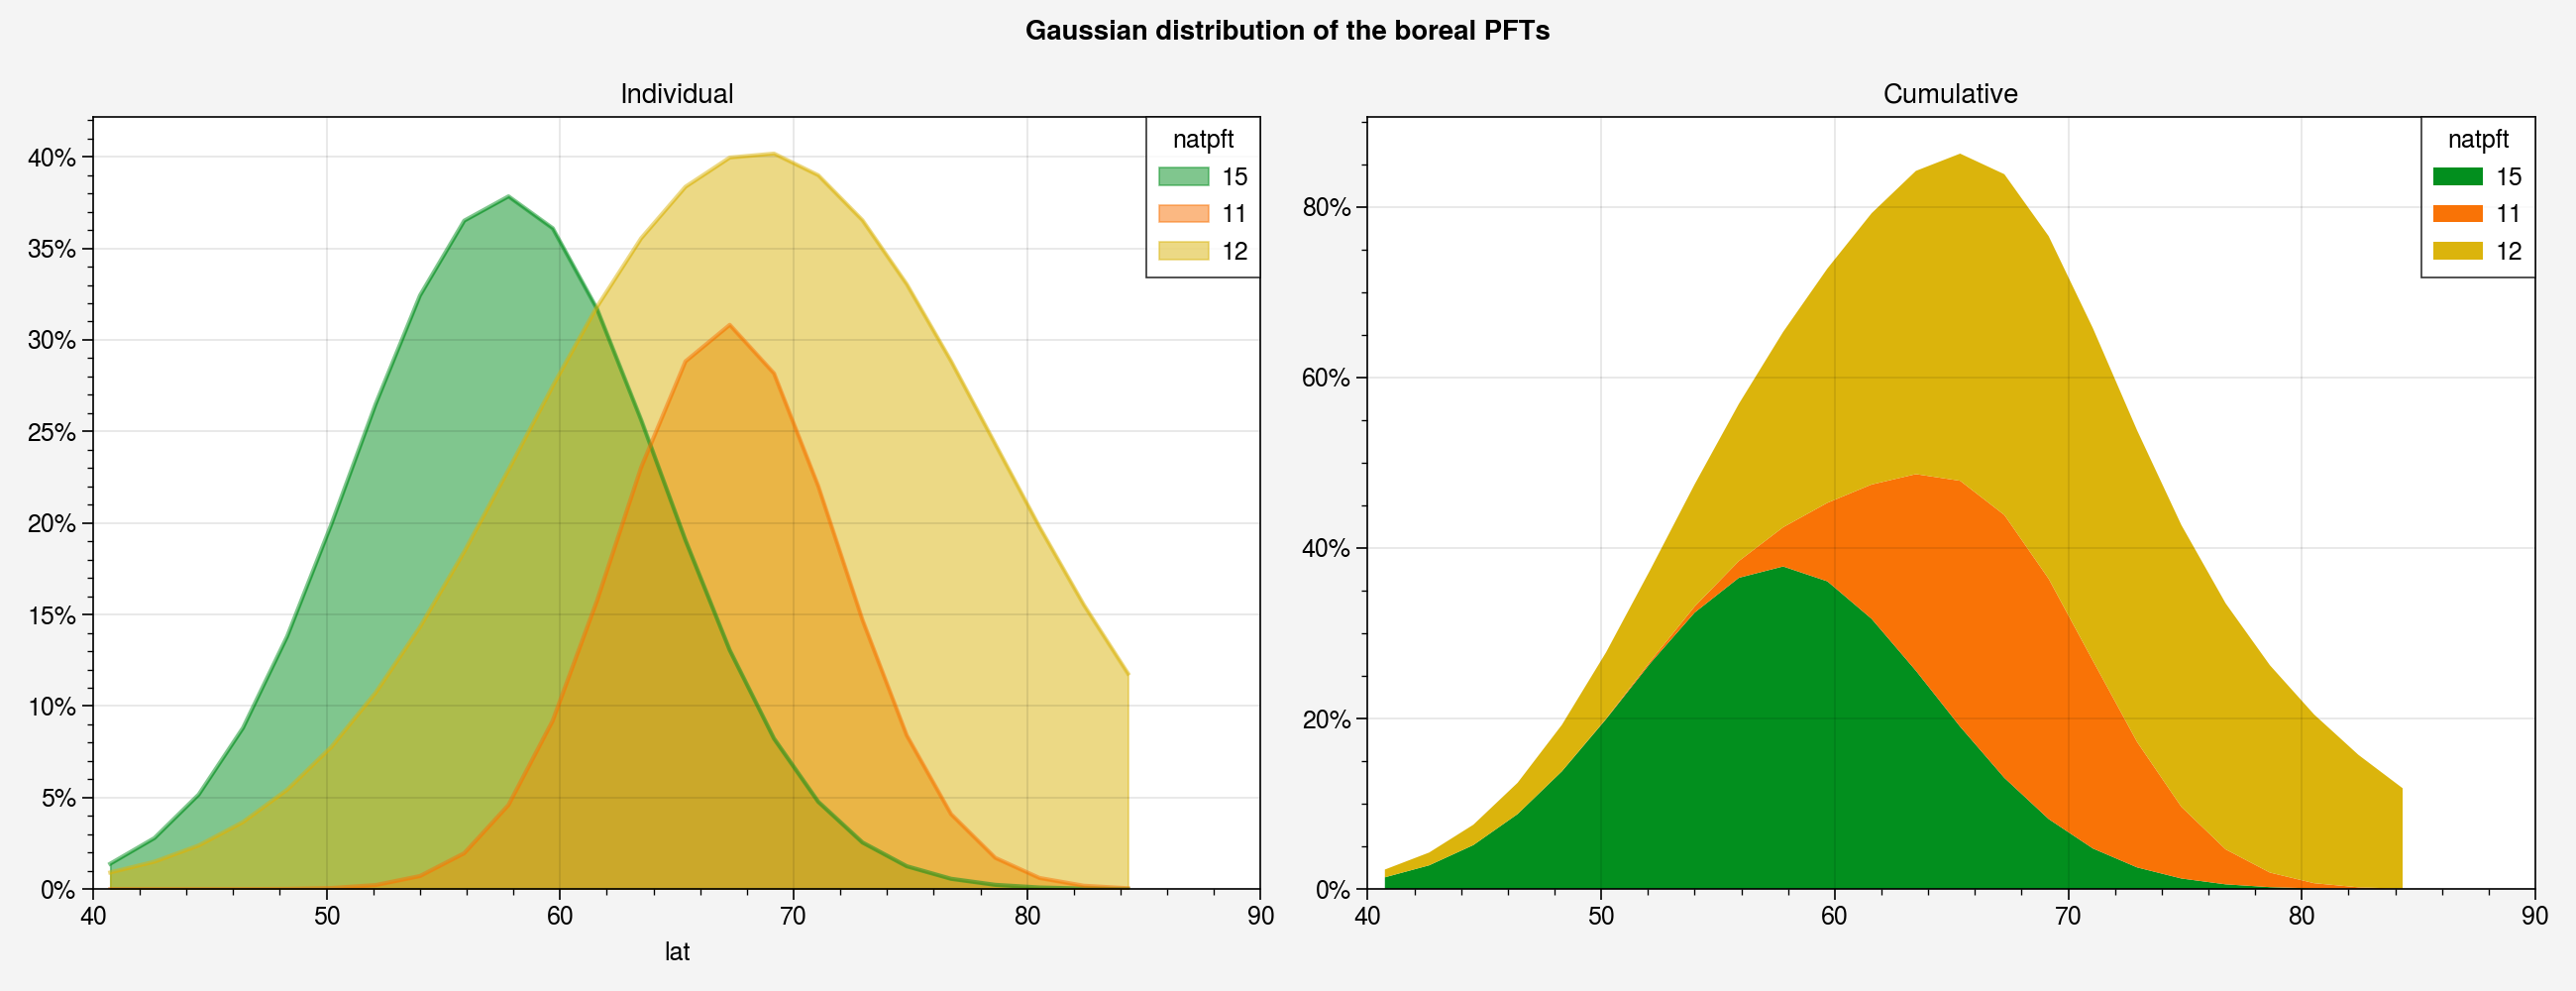

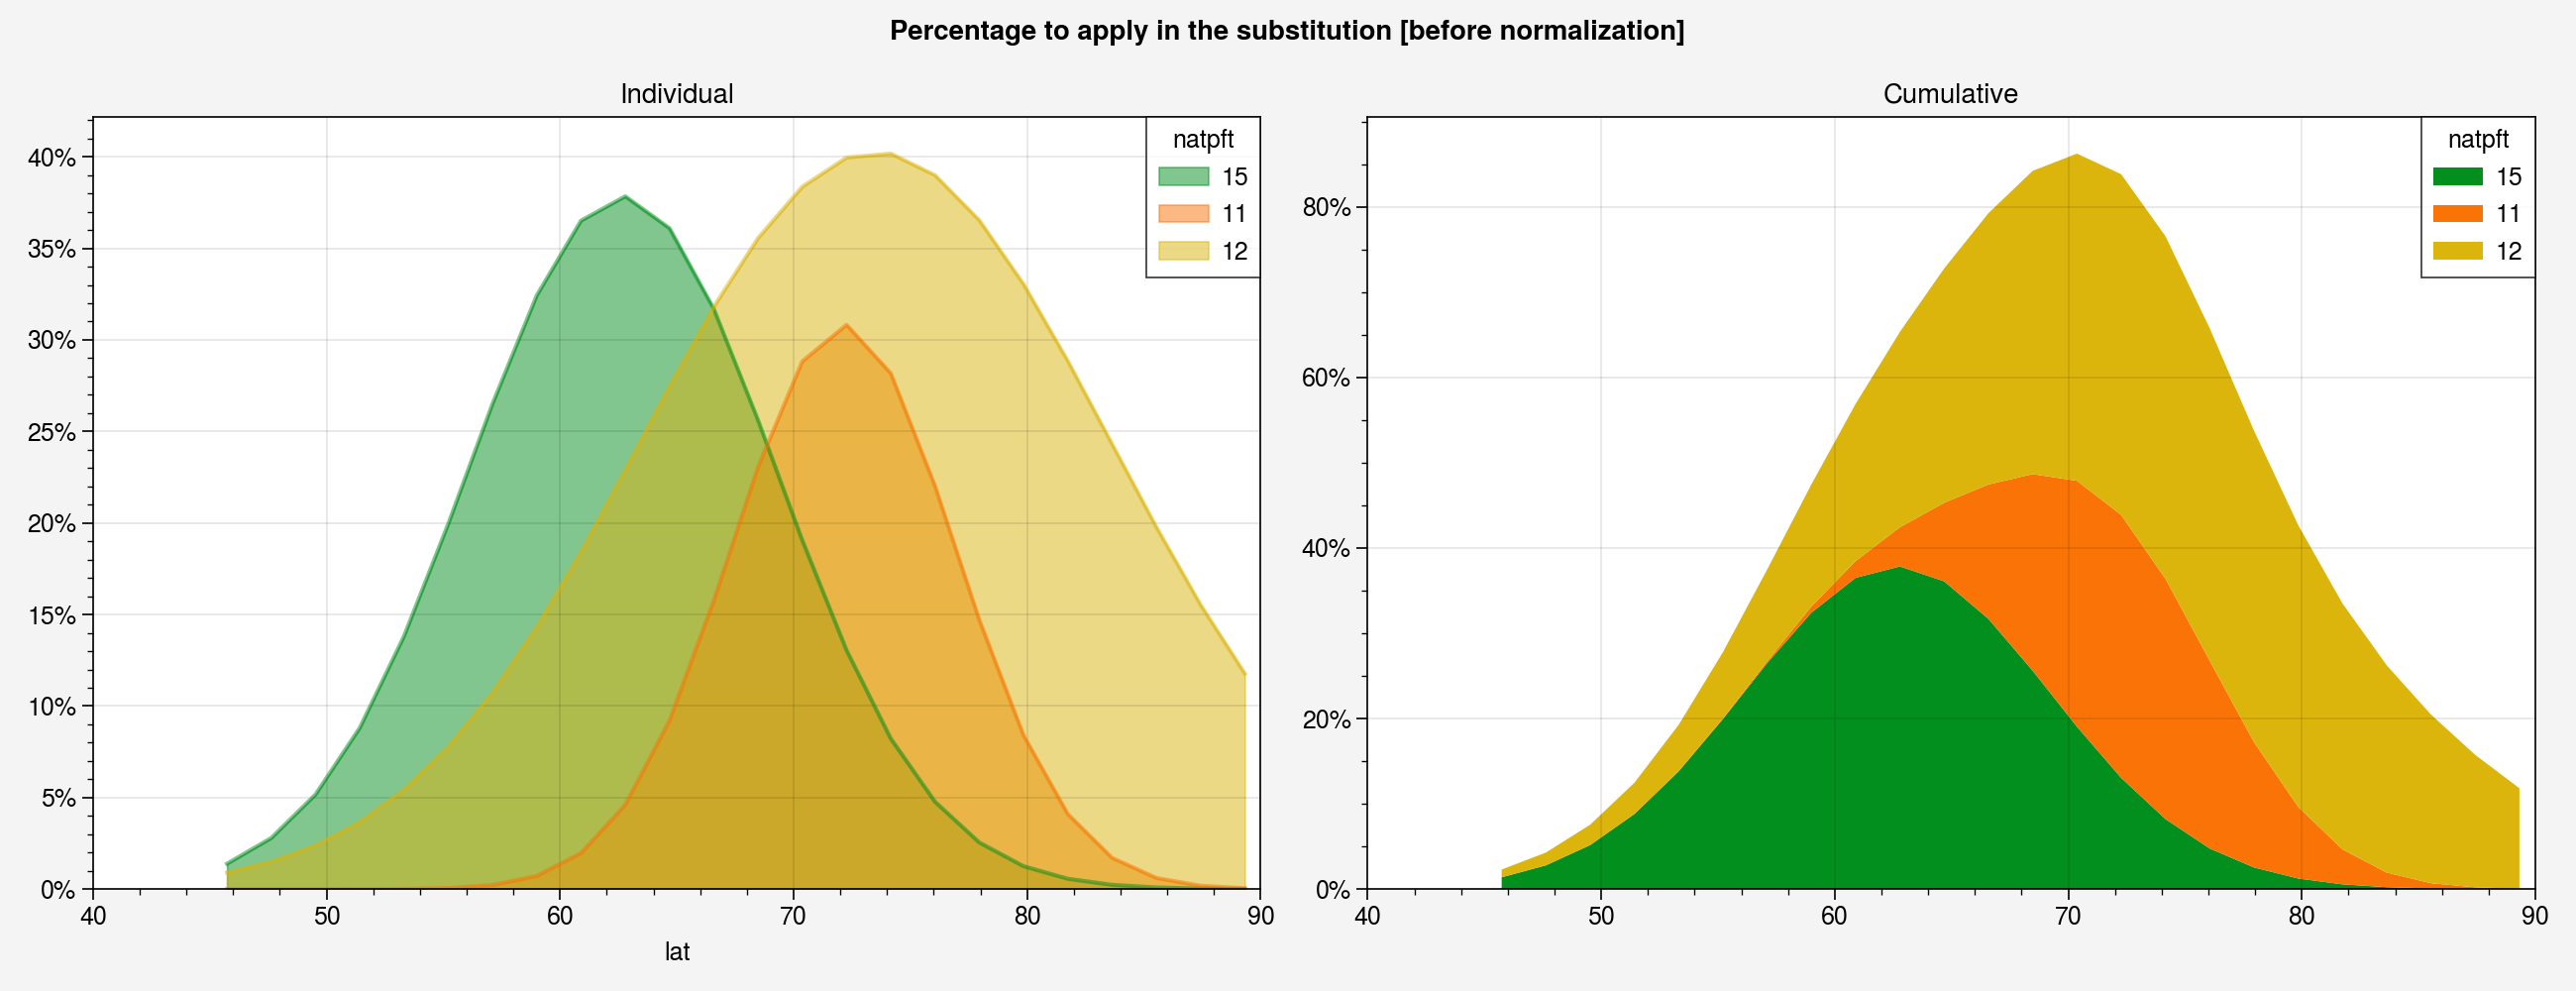

In [47]:
def plot_individual_cumulative(ds_x, ds_y, col, title=None): #other parameters can be set, but this func is ad hoc
    
    fig, axes = plt.subplots(1,2,figsize=(13, 5))
    series = ds_y.to_series().unstack()
    #series.plot.bar(ax=ax, stacked=True)
    p=series.plot.area(ax=axes[0], stacked=False, title="Individual", color=col)
    legend = axes[0].get_legend()
    leg=[]; [leg.append(t.get_text()) for t in legend.texts]

    axes[1].stackplot(ds_x, ds_y.T, colors = col)
    axes[1].legend(leg, title = legend.get_title().get_text())
    axes[1].set_title("Cumulative")

    for b, ax in enumerate(axes.flat):
        vals = ax.get_yticks()
        ax.set_yticklabels(['{0:g}%'.format(x) for x in vals])
        ax.set_xlim(40,90)

    plt.suptitle(title)

    plt.tight_layout()
    plt.show()
    
plot_individual_cumulative(ds_x = ds_lat_m.lat, ds_y = ds_lat_m.gaussfit.rename(''), 
                           title = "Gaussian distribution of the boreal PFTs", col=colors)

############## Apply the shift ############
shift=5.
lat_shift_perc=ds_lat_m.gaussfit.rename('').copy()
lat_shift_perc=lat_shift_perc.assign_coords({'lat': lat_shift_perc.lat+shift})
#filter if the shift is too high
lat_shift_perc=lat_shift_perc.where(lat_shift_perc.lat<=90.)

plot_individual_cumulative(ds_x = lat_shift_perc.lat, ds_y = lat_shift_perc, 
                           title = "Percentage to apply in the substitution [before normalization]", col=colors)

## Normalization: from distribution to proxy for the percentage to subsitute

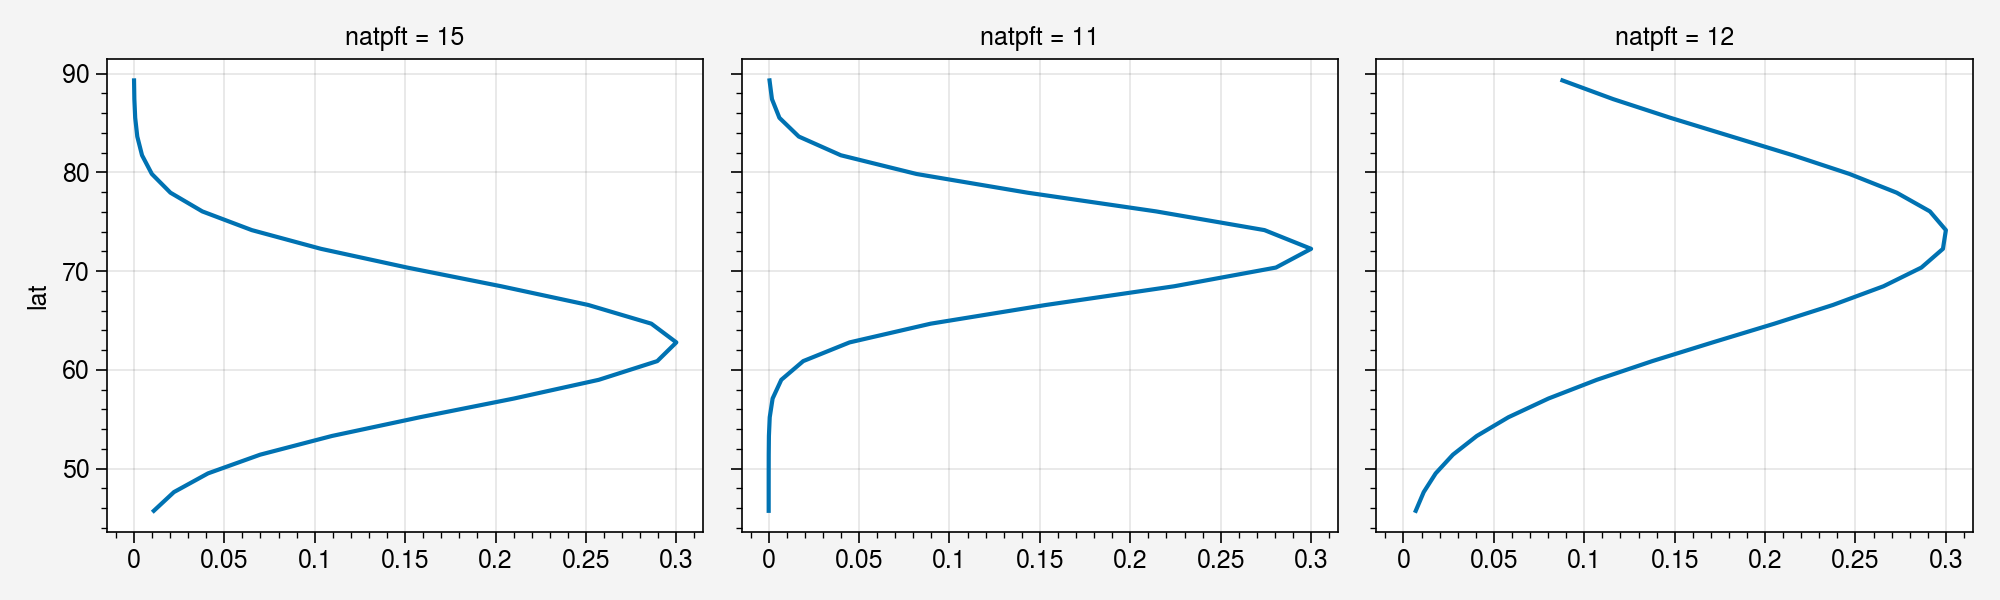

In [48]:
norm_factor=0.3 #30%
lat_shift_perc = lat_shift_perc/lat_shift_perc.max(dim='lat')*norm_factor
lat_shift_perc.plot(y='lat',col='natpft')

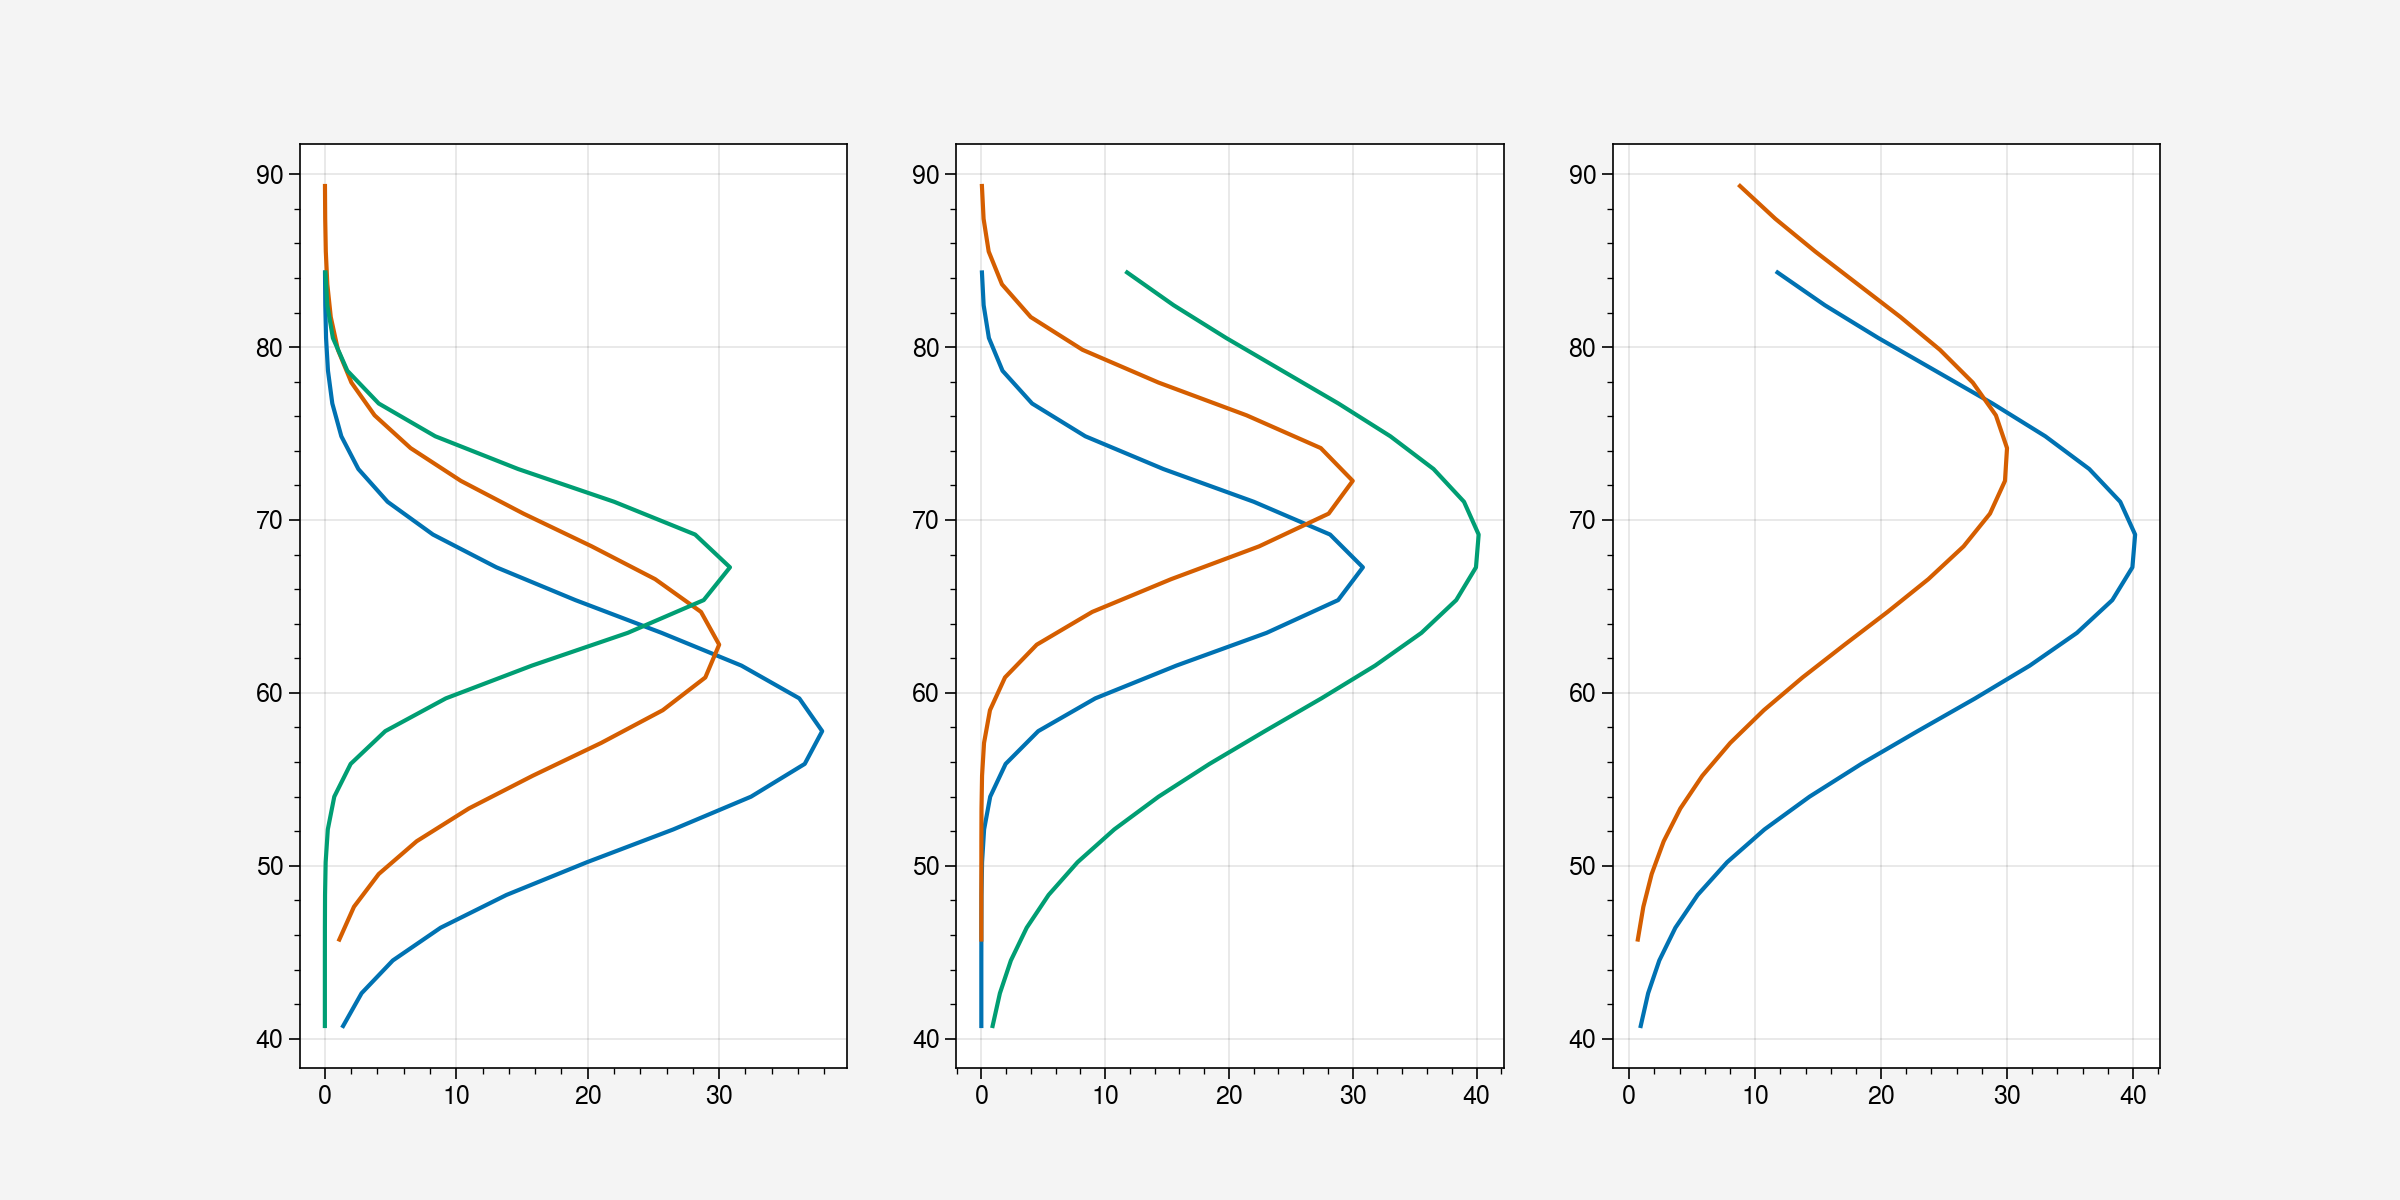

In [49]:
fig, axes = plt.subplots(1,3, figsize=[12,6])

bpfts_m = [15, 11, 12]

lat_perc = ds_lat_m.gaussfit.rename('').copy()

for b, ax in enumerate(axes.flat):
    ax.plot(lat_perc.sel(natpft= bpfts_m[b]),lat_perc.lat)#, label=bpfts_m[b])
    ax.plot(lat_shift_perc.sel(natpft= bpfts_m[b])*100, lat_shift_perc.lat, label=bpfts_m[b])
    if b<2:
        ax.plot(lat_perc.sel(natpft= bpfts_m[b+1]), lat_perc.lat, label=bpfts_m[b+1])

In [50]:
#plt.stackplot(lat_perc.lat, lat_perc.sel(natpft= bpfts_m[b]))
#plt.stackplot(lat_shift_perc.lat, lat_shift_perc.sel(natpft= bpfts_m[b])*100)

In [51]:
ax.set_ylim(0,48)
ax.set_yticklabels(['{0:g}%'.format(x) for x in ax.get_yticks()])
ax.set_title('natpft = '+str(bpfts[b]))
if b==3 or b==4:
    ax.set_xlabel('Latitude [°]')
if b==0:
    ax.legend()

In [52]:
#lat_ax = fig.add_subplot(grid[:-1, 0], sharey=main_ax, ylabel='Latitude [°]') #xticklabels=[],
#df = pfts_lat.sel(natpft=n).drop('natpft').rename('Latitude [°]').to_series().rename_axis('')
#base = plt.gca().transData
#rot = transforms.Affine2D().rotate_deg(90)
#reflect_vertical = transforms.Affine2D(np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]]))
#df.plot(kind='area', ax=plt.gca(),transform= reflect_vertical + rot + base, stacked=False, color='g',xlim=(0, pfts_lat.sel(natpft=n).max()+3), ylim=(-90,90))
#plt.gca().invert_xaxis() #same as lat_ax.invert_xaxis()

### <div class="alert alert-info">Comments:</div>
- **Add a coordinate value** to Xarray DataArray: `assign_coords()` + `expand_dims()` -> `xr.concat()` (that needs to have dimension along which concatenate and the two datasets in a tuple () - round brakets)

`da = da.assign_coords({"natpft":15}).expand_dims('natpft')
boreal_pfts_macro = xr.concat((da, ds), dim='natpft')`

- **Reorder of a coordinate values**: `ds.sel(dim=[new order])`
- *How do I by Xarray*: https://docs.xarray.dev/en/stable/howdoi.html
- **Get the legend** from an existing legend: `get_legend()` and then [need to access the `Legend` type](https://stackoverflow.com/questions/44465242/getting-the-legend-label-for-a-line-in-matplotlib). It's made of [Artist](https://matplotlib.org/stable/api/artist_api.html#matplotlib.artist.Artist).
- **Inline for loop**: https://stackoverflow.com/questions/27411631/inline-for-loop
`

In [53]:
#boreal_trees = boreal_pfts.isel(natpft=[0,1,2]).sum('natpft')
#boreal_trees.mean('lon').plot(y='lat'); plt.tight_layout(); plt.show()
#boreal_shrubs = boreal_pfts.sel(natpft=11)
#boreal_grass = boreal_pfts.sel(natpft=12)

# 2. Longitude function

<span style="color:red"> **NOTE: remember this distribution come from cutting latitude over 40 degrees**. Since this is useful to find the relative contribution over the Boreal trees is not that essential to care about, but if I use it for other purposes than it is needed to be more careful on the choice to make</span>

This will be instead the percentage to apply in the decomposition within the 3 groups: trees, shrubs and grass.

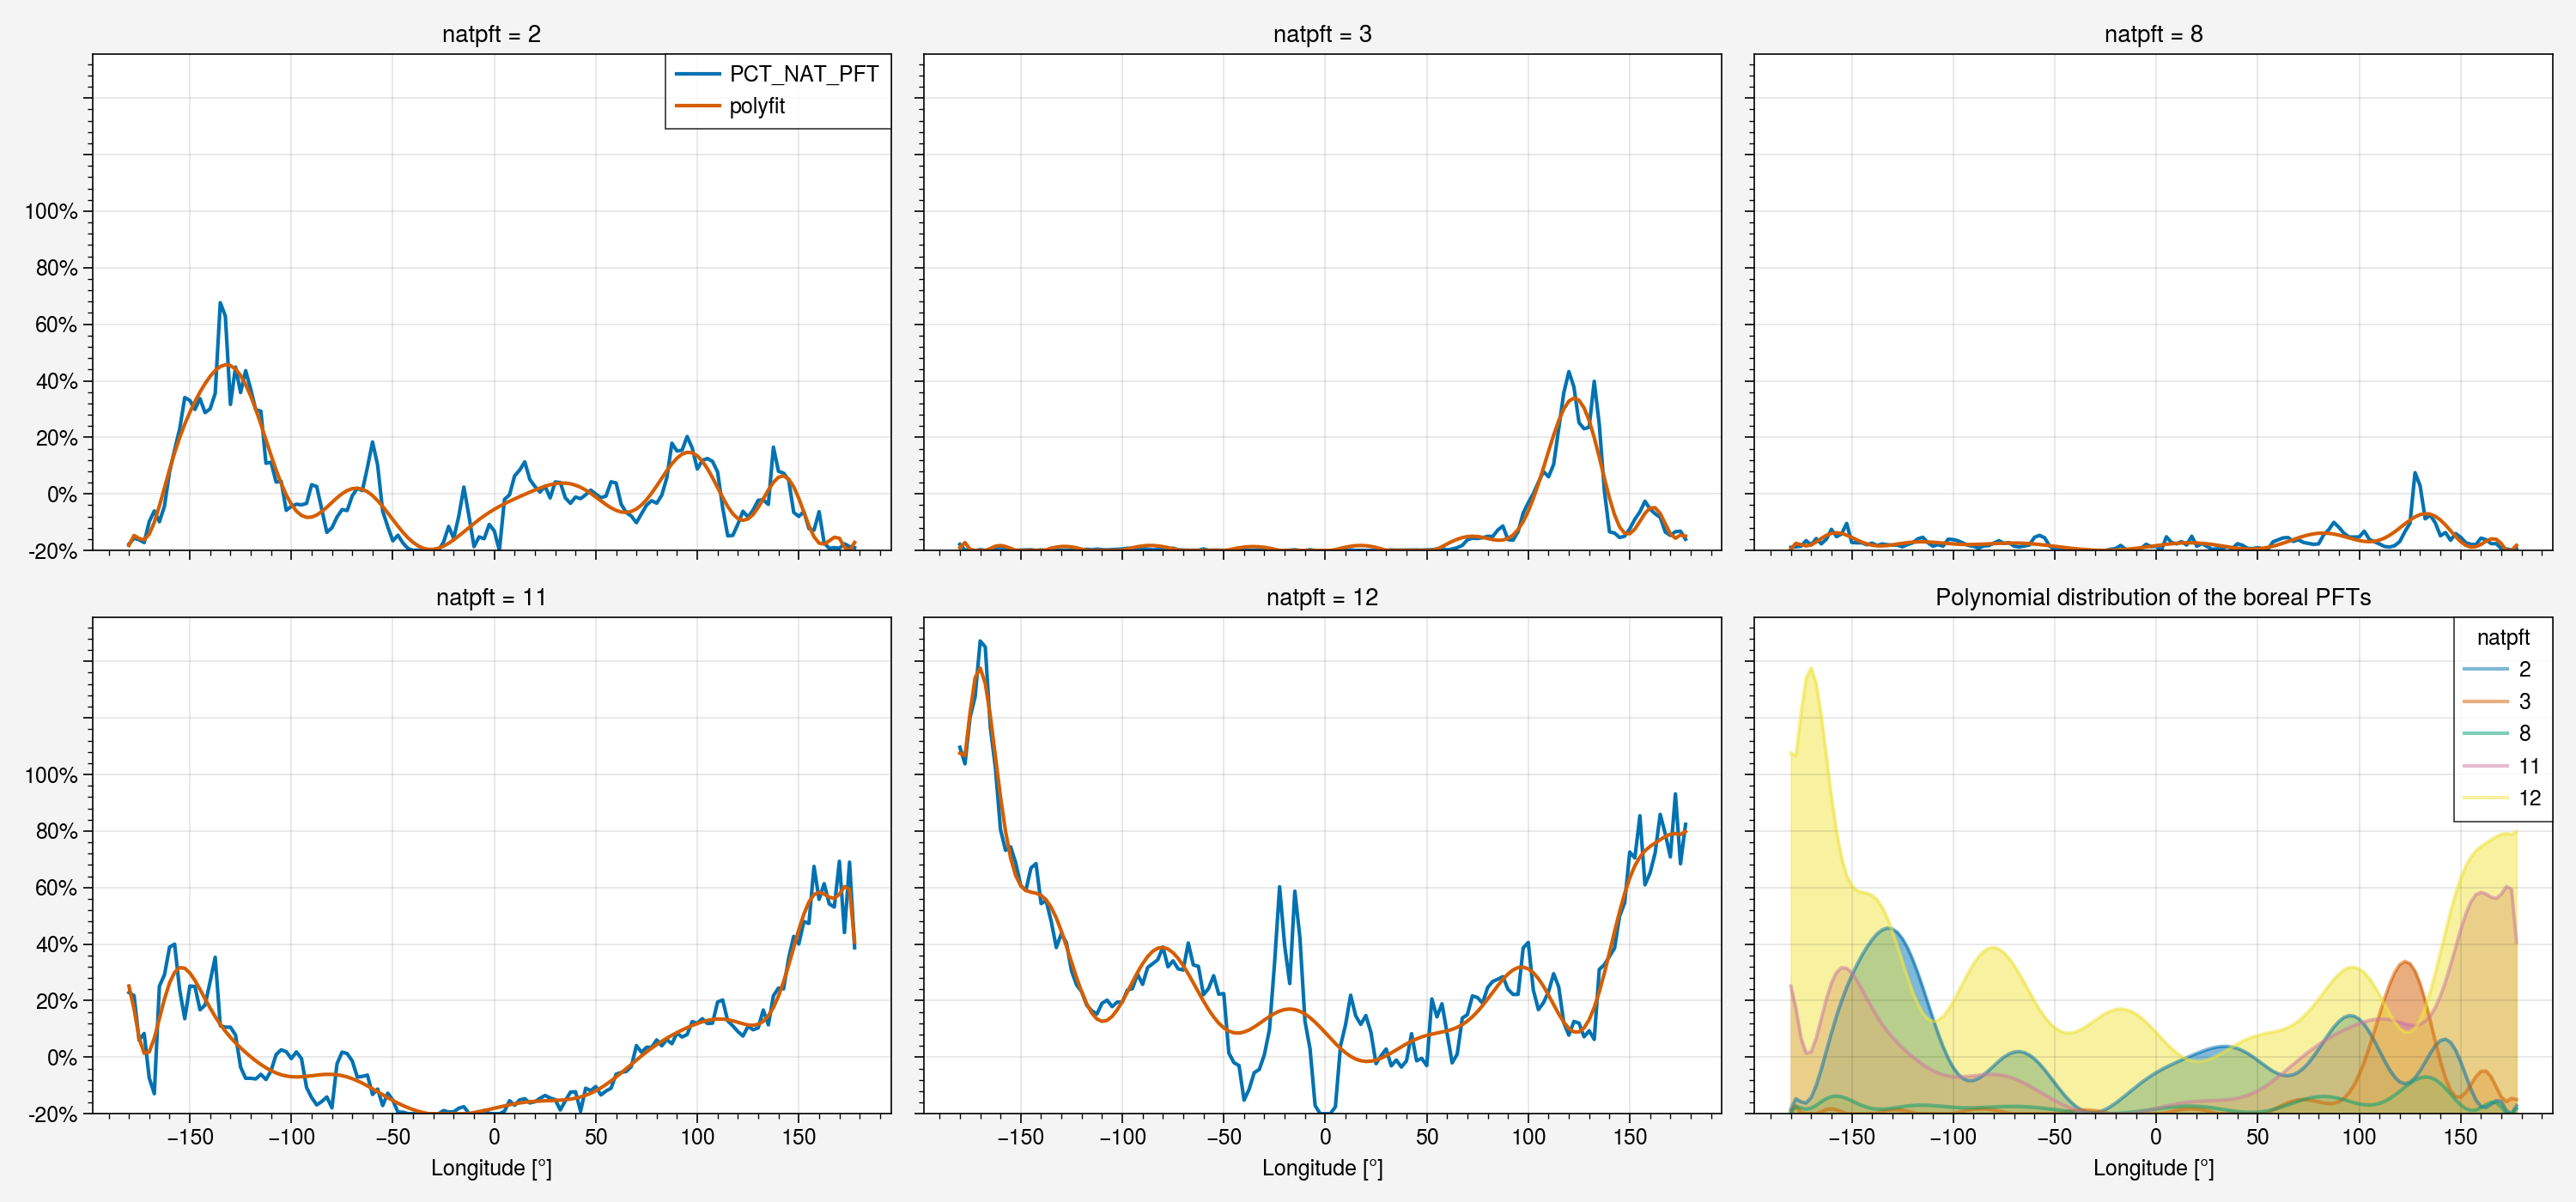

In [54]:
ds = boreal_pfts.copy()
ds_lon=ds.mean('lat').fillna(0.)
#ds_lon.plot(col='natpft', col_wrap=3)
#plt.show()

out = ds_lon.polyfit(dim="lon", deg=20, full=True)
polyfit = xr.polyval(coord=ds_lon.lon, coeffs=out.polyfit_coefficients).rename('polyfit')
#filter negative, irrealistic values
polyfit=polyfit.where(polyfit>0., 0.)
#polyfit.plot(col='natpft', col_wrap=3)
#plt.show()

ds_lon = xr.merge([ds_lon, polyfit.T])#.plot.line(x='lat',col='natpft', col_wrap=3) #.rename('rawdata')

lines = ['PCT_NAT_PFT','polyfit']

fig, axes = plt.subplots(2, 3, figsize=[15,7], sharex=True, sharey=True)
#fig.delaxes(axes.flatten()[5])

for b, ax in enumerate(axes.flat):
    if b == 5:
        #continue
        #ax.legend(handles=lines)
        #ax.set_visible(False)
        series = ds_lon['polyfit'].T.rename('').to_series().unstack()
        series.plot.area(ax=ax, stacked=False)
        #ax.plot(ds_lon.lon, ds_lon['polyfit'].T)
        ax.legend(bpfts, title='natpft')
        ax.set_xlabel('Longitude [°]')
        ax.set_title("Polynomial distribution of the boreal PFTs")
    else:
        for l in lines:
            ax.plot(ds_lon.lon, ds_lon.isel(natpft= b)[l], label=l)
            #ax.set_ylim(0,90)
            ax.set_yticklabels(['{0:g}%'.format(x) for x in ax.get_yticks()])
            ax.set_title('natpft = '+str(bpfts[b]))
            if b==3 or b==4:
                ax.set_xlabel('Longitude [°]')
            if b==0:
                ax.legend()

#fig.add_axes()
#axes.flat[-1].legend(lines)
plt.tight_layout()
#plt.legend(lines)
plt.show()

In [55]:
# Here try to fix some biases of the polyfit (without managing)
#bor3 = ds_lon['polyfit'].sel(natpft=3).copy()
#ds_lon['polyfit'].sel(natpft=3).values = bor3.where(bor3.lon > 65., 0.)
#ds_lon['polyfit'].plot(col='natpft')

## 2b. Distribution of trees in longitude

In [56]:
# BOREAL NAT PDFs:

# - 2: NET Boreal
# - 3: NDT Boreal
# - 8: BDT Boreal
# ----= 15 Boreal Trees

# - 11: BDS Boreal
# - 12: artic C3 grass

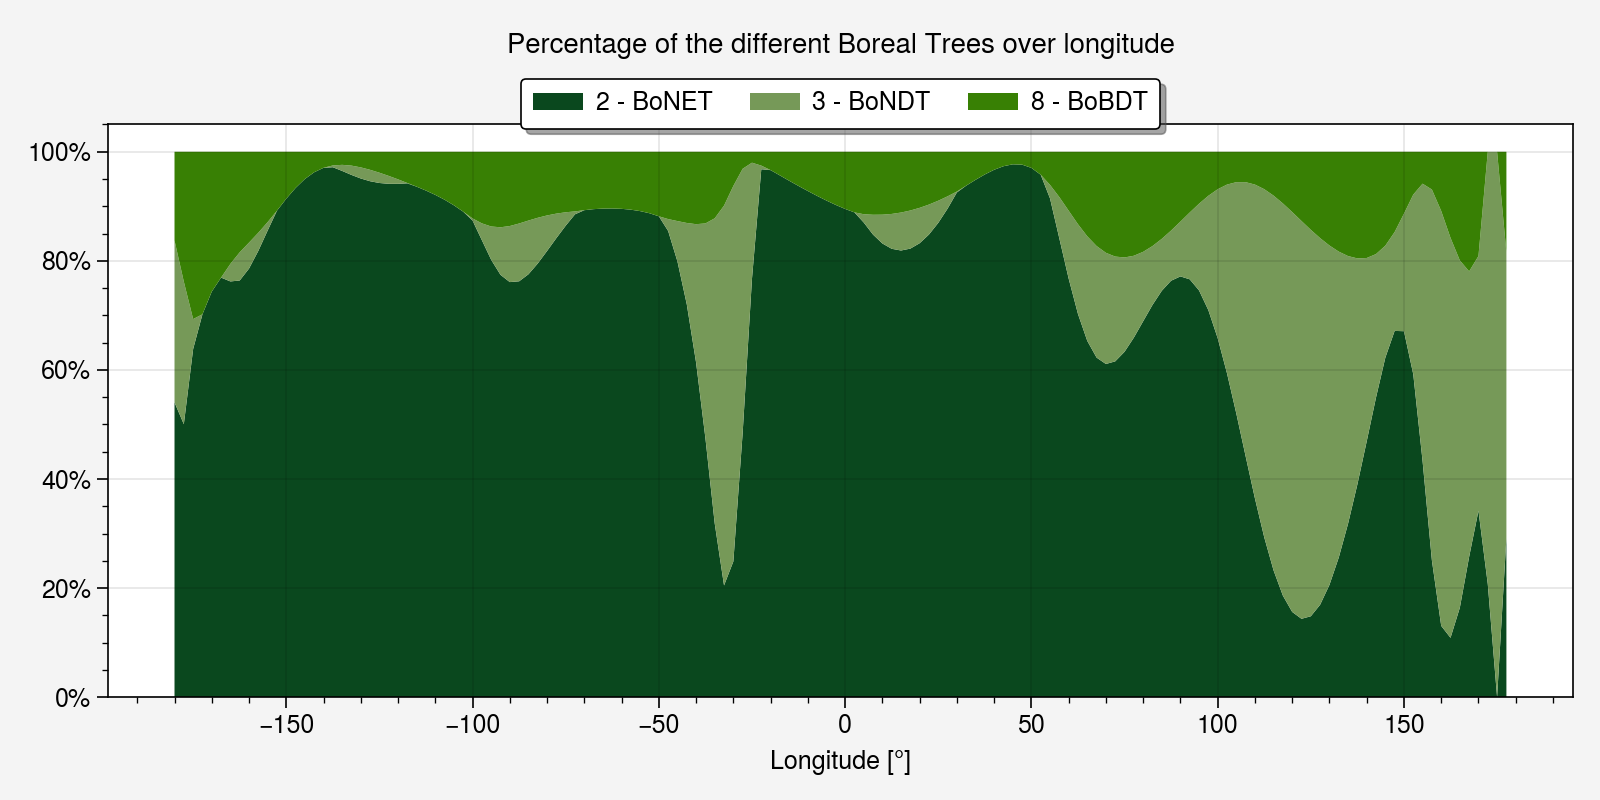

In [57]:
tree_lon_perc= ds_lon['polyfit'].sel(natpft=[2,3,8]).rename('')
tree_lon_perc=tree_lon_perc/tree_lon_perc.sum('natpft').values*100
#tree_norm.plot.line()
legend = ['2 - BoNET', '3 - BoNDT', '8 - BoBDT']
fig, ax = plt.subplots(1, figsize=[8, 4])
plt.stackplot(tree_lon_perc.lon, tree_lon_perc, colors=["pine green","moss","dark grass green"])
vals = ax.get_yticks()
ax.set_yticklabels(['{0:g}%'.format(x) for x in vals])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
#ax.legend(legend, loc='center left', bbox_to_anchor=(0.97, 0.7))
#ax.legend(legend, loc='right')
ax.legend(legend, loc='upper center', bbox_to_anchor=(0.5, 1.08),
          fancybox=True, shadow=True, ncol=5)
ax.set_title("Percentage of the different Boreal Trees over longitude", y=1.1)
ax.set_xlabel("Longitude [°]")
plt.tight_layout()
plt.show()

# 4. Replacement

Rule:
- Trees -> shrubs: [2,3,4] -> [11]
- Shrubs -> grass: [11] -> [12]
- Grass -> bg ??

1. you need to broadcast lat and lon 
2. apply to shrub perc -> substract to shrubes and add to trees..etc
3. check normalization

### Steps:
0. Actual configuration: `boreal_pfts_m`
1. Extract latitude for each grid cell (over the boreal_lat) and find the correspondent perc for the replacement in `lat_shift_perc`, for each PFT [15,11,12] -> evaluate the overall replacement (`presence_perc * lat_shift_perc = replecement_perc`)
2. The `replecement_perc` data is then subtracted by the [11,12,0?] and added to [15,11,12]
3. Check normalisation.

### 0. Actual configuration: `boreal_pfts_m`

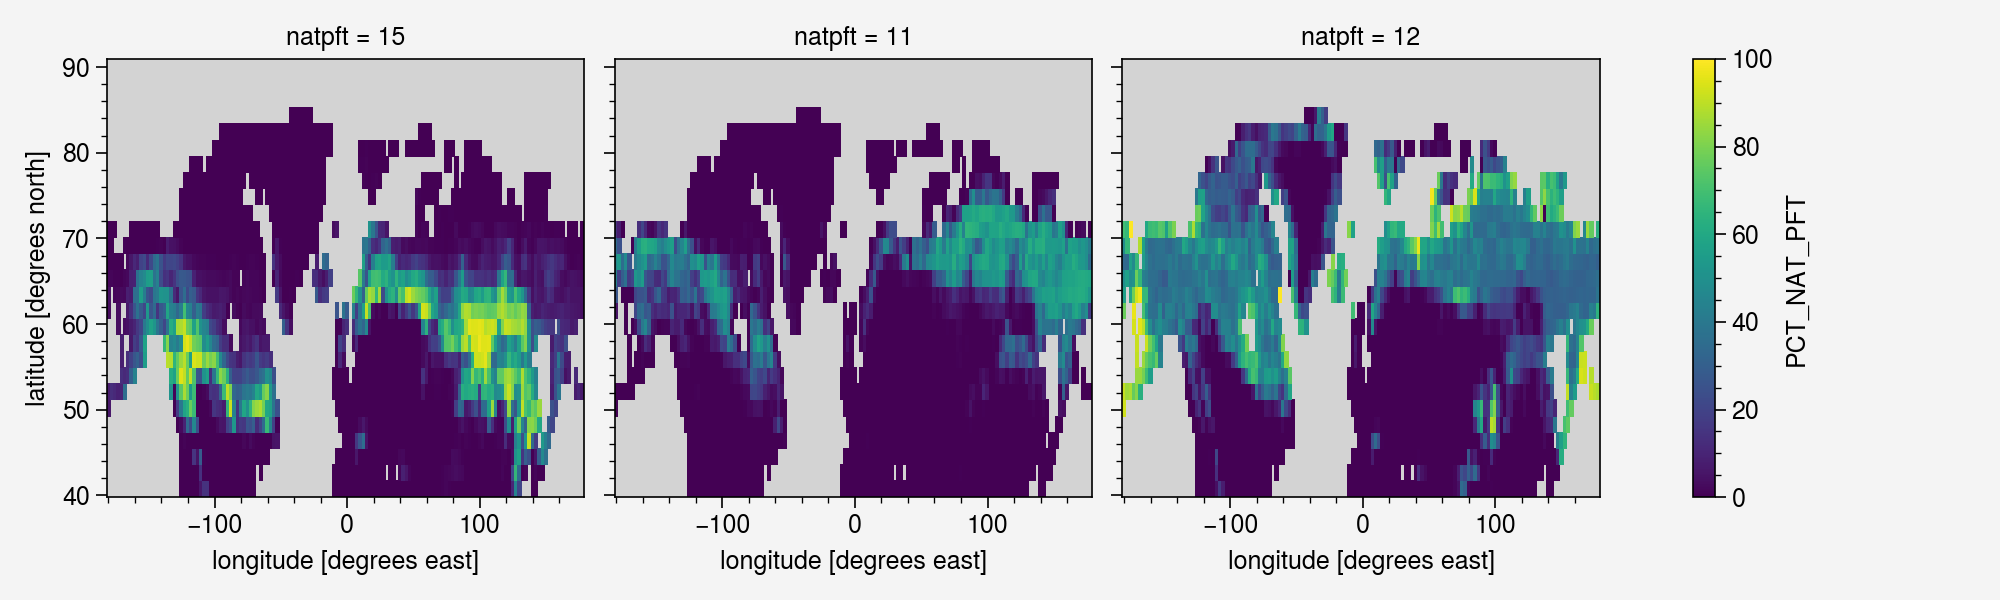

In [58]:
boreal_pfts_macro.plot(col='natpft', subplot_kws=dict(facecolor="lightgray"))

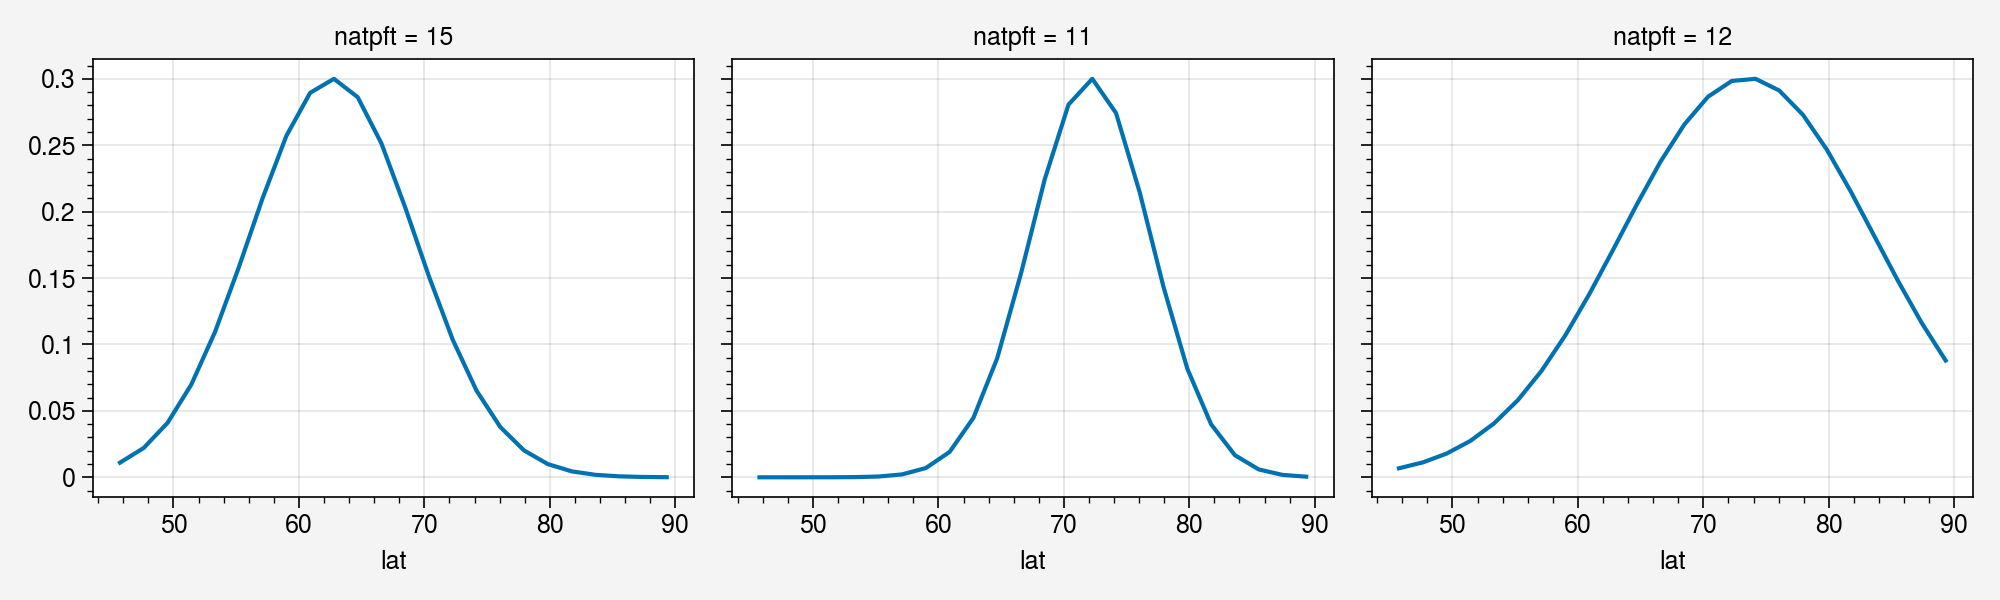

In [59]:
lat_shift_perc.plot(col='natpft')

### 1. Evaluate the overall replacement (`replecement_perc`)
`replecement_perc = presence_perc * lat_shift_perc`

**Extract latitude for each grid cell (over the boreal_lat) and find the correspondent perc for the replacement in `lat_shift_perc`, for each PFT [15,11,12].**

<span style="color:red"> **NOTE**: The lat coordinates do not correspond --> **interpolate with quadratic method** to match lat and fill nan values interpolationg again but forcing the extremes to 0 (otherwise it does not work).
This lead to not a smooth curve --> I tried to fix the extremes of the fitting, but the sigma parameter is not supported by curvefit of Xarray. Also I should be careful with the shifting afterwards.</span>

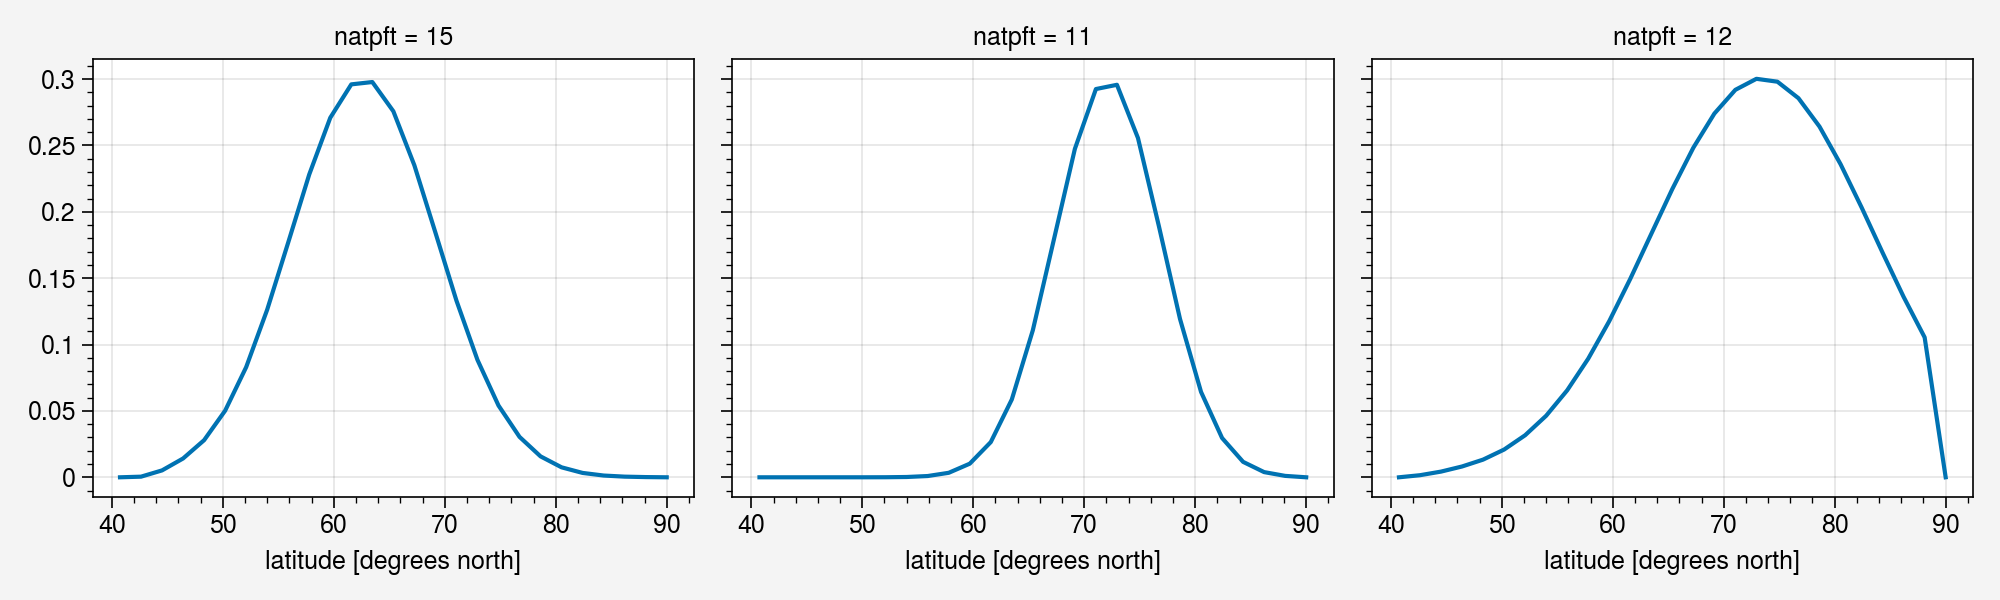

In [60]:
da = lat_shift_perc.interp(lat=boreal_pfts_macro['lat'], method='quadratic')#.plot(col='natpft')
da[0]=0.; da[-1]=0.
lat_shift_perc = da.interpolate_na(dim='lat', method='quadratic')
lat_shift_perc.plot(col='natpft')

### Replacement: trees -> shrubs; shrubs -> grass (rolling `lat_shift_perc`)

<span style="color:red"> **NOTE:** this is not the perfect way to do it: then grass is in natpft of trees. But just remember to drop it later </span>

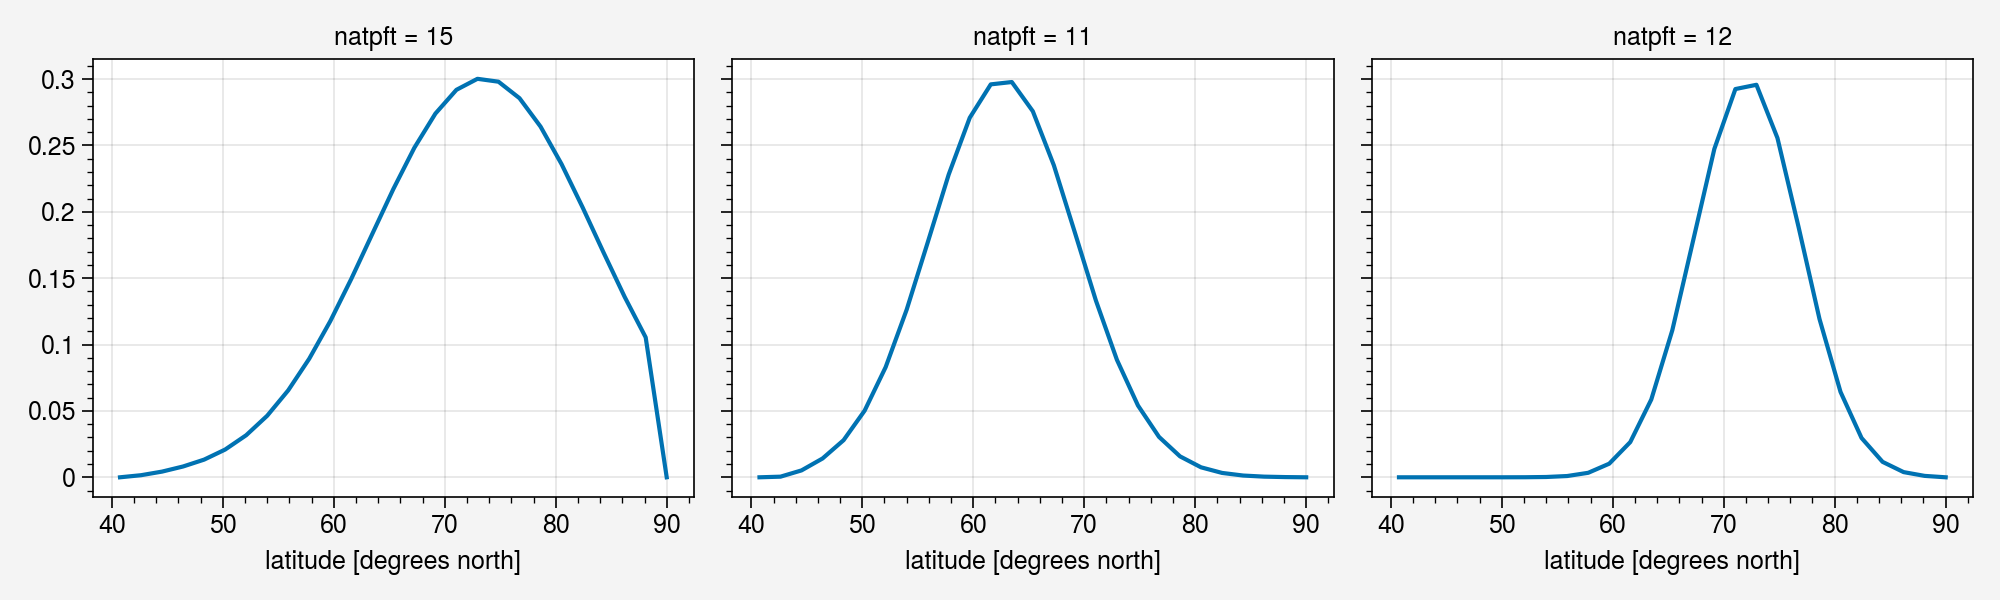

In [61]:
lat_shift_perc = lat_shift_perc.roll(natpft=1)
lat_shift_perc.plot(col='natpft')

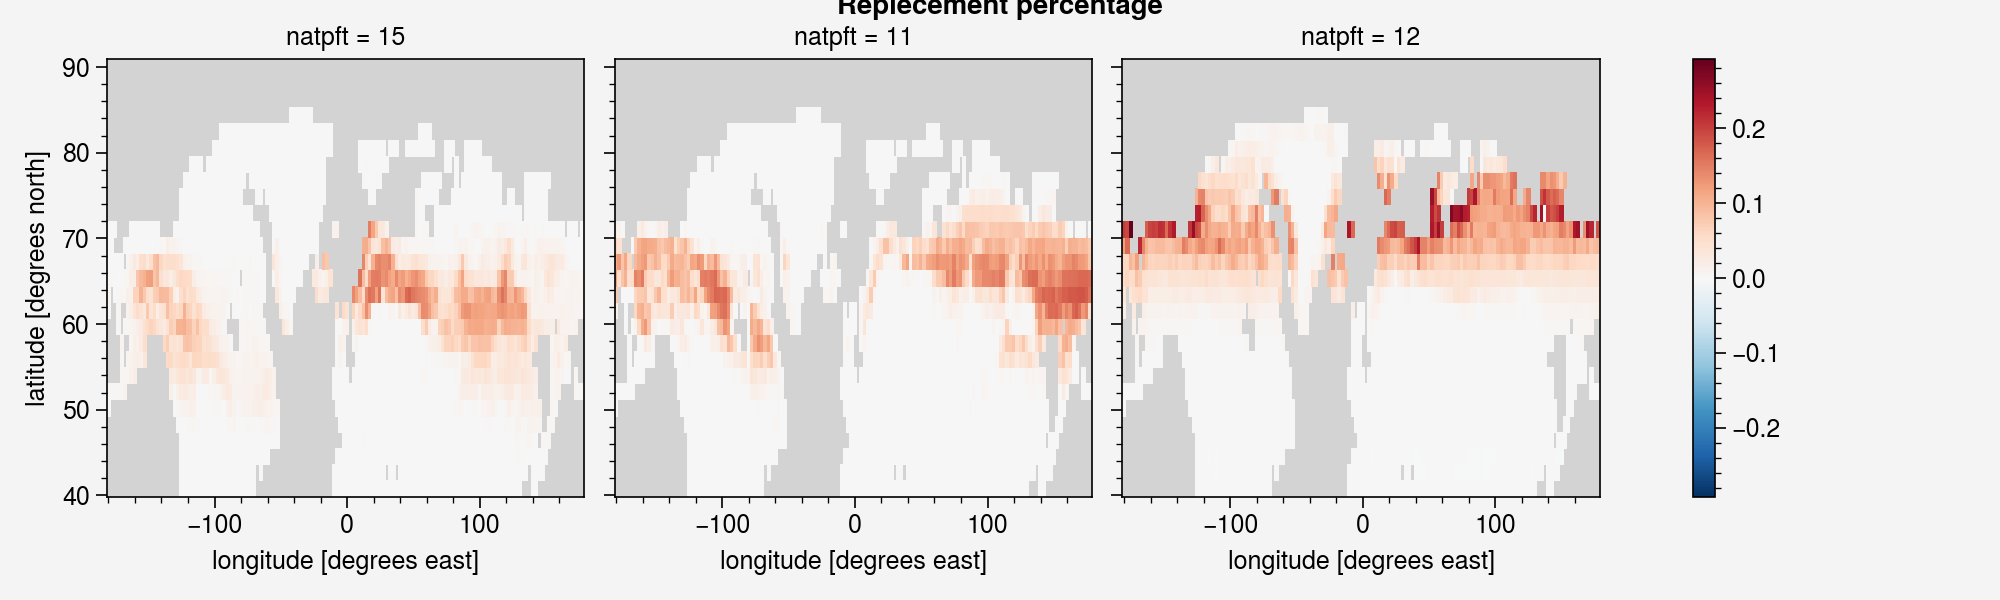

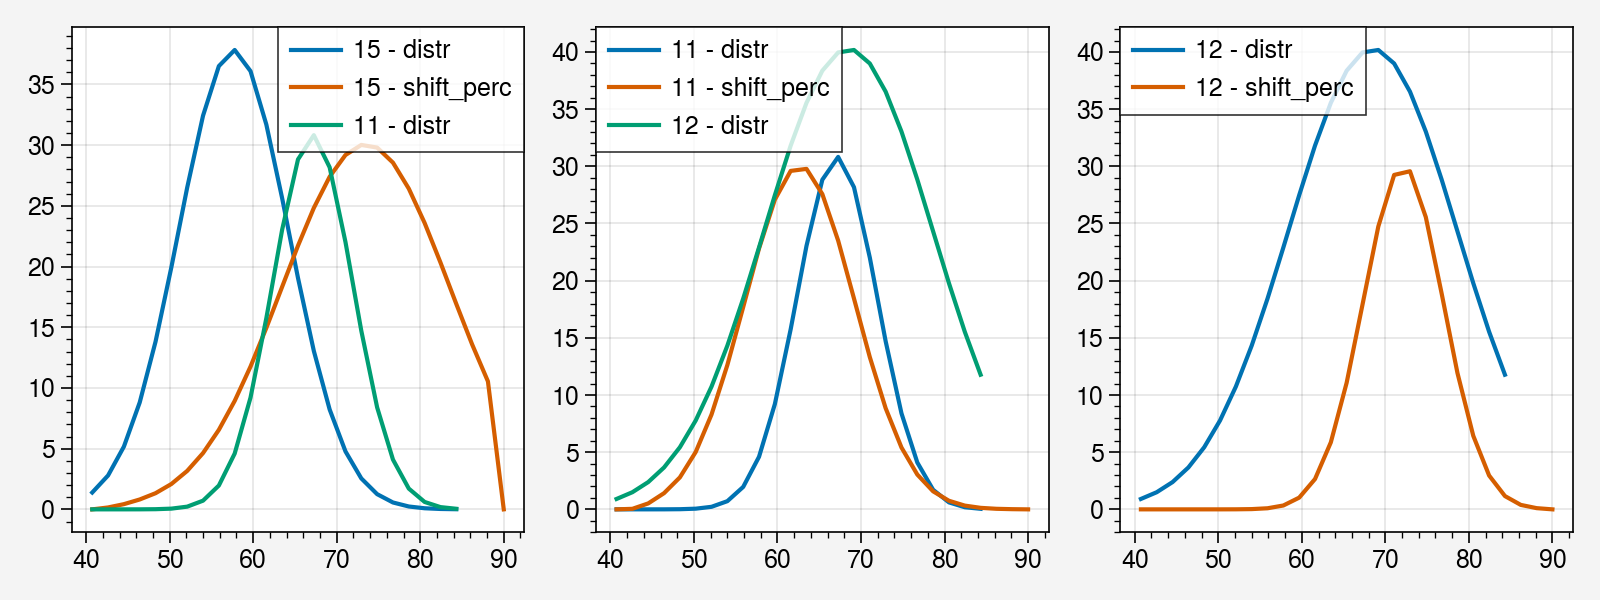

In [62]:
def weight_da(da, dim, weighting):
    """
    Weights a DataArray along a specific dimension
    """
    
    assert da[dim].size == weighting[dim].size
    #Weighting vector must be the same size as the dimension

    old_order = da.dims
    new_order = tuple(list(set(old_order) - set([dim])) + [dim]) 

    da = da.transpose(*new_order)
    da_weighted = da * weighting
    da_weighted = da_weighted.transpose(*old_order)

    return da_weighted

replecement_perc = weight_da(boreal_pfts_macro, 'lat', lat_shift_perc)/100.
replecement_perc.plot(col='natpft', subplot_kws=dict(facecolor="lightgray"))
#p.axes.coastlines()
plt.suptitle("Replecement percentage", y=1.01)
#plt.tight_layout()
plt.show()

###### HERE NEEDS TO BE CORRECTED #######

fig, axes = plt.subplots(1,3, figsize=[8,3])
bpfts_m = [15, 11, 12]
lat_perc = ds_lat_m.gaussfit.rename('').copy()

for b, ax in enumerate(axes.flat):
    ax.plot(lat_perc.lat, lat_perc.isel(natpft= b), label=str(bpfts_m[b])+" - distr")
    ax.plot(lat_shift_perc.lat, lat_shift_perc.isel(natpft= b)*100, label=str(bpfts_m[b])+" - shift_perc")
    if b<2:
        ax.plot(lat_perc.lat, lat_perc.isel(natpft= b+1), label=str(bpfts_m[b+1])+" - distr")
    ax.legend()
        
plt.tight_layout()
plt.show()

### Testing the operation of multiplication along axis

In [63]:
for la in range(len(boreal_pfts_macro.lat.values)):
    for lo in range(len(boreal_pfts_macro.lon.values)):
        for na in range(len(boreal_pfts_macro.natpft.values)):
            a = boreal_pfts_macro.isel(lat=la, lon=lo, natpft=na).values
            b = lat_shift_perc.isel(lat=la, natpft=na).values
            c = a*b/100.
            d = replecement_perc.isel(lat=la, lon=lo, natpft=na).values
            np.testing.assert_equal(c, d)
            #assert math.isclose(c,d, rel_tol=0.00000002)
print("Test on replecement done √")

Test on replecement done √


### 2. The `replecement_perc` data is then subtracted by the [11,12,0?] and added to [15,11,12]

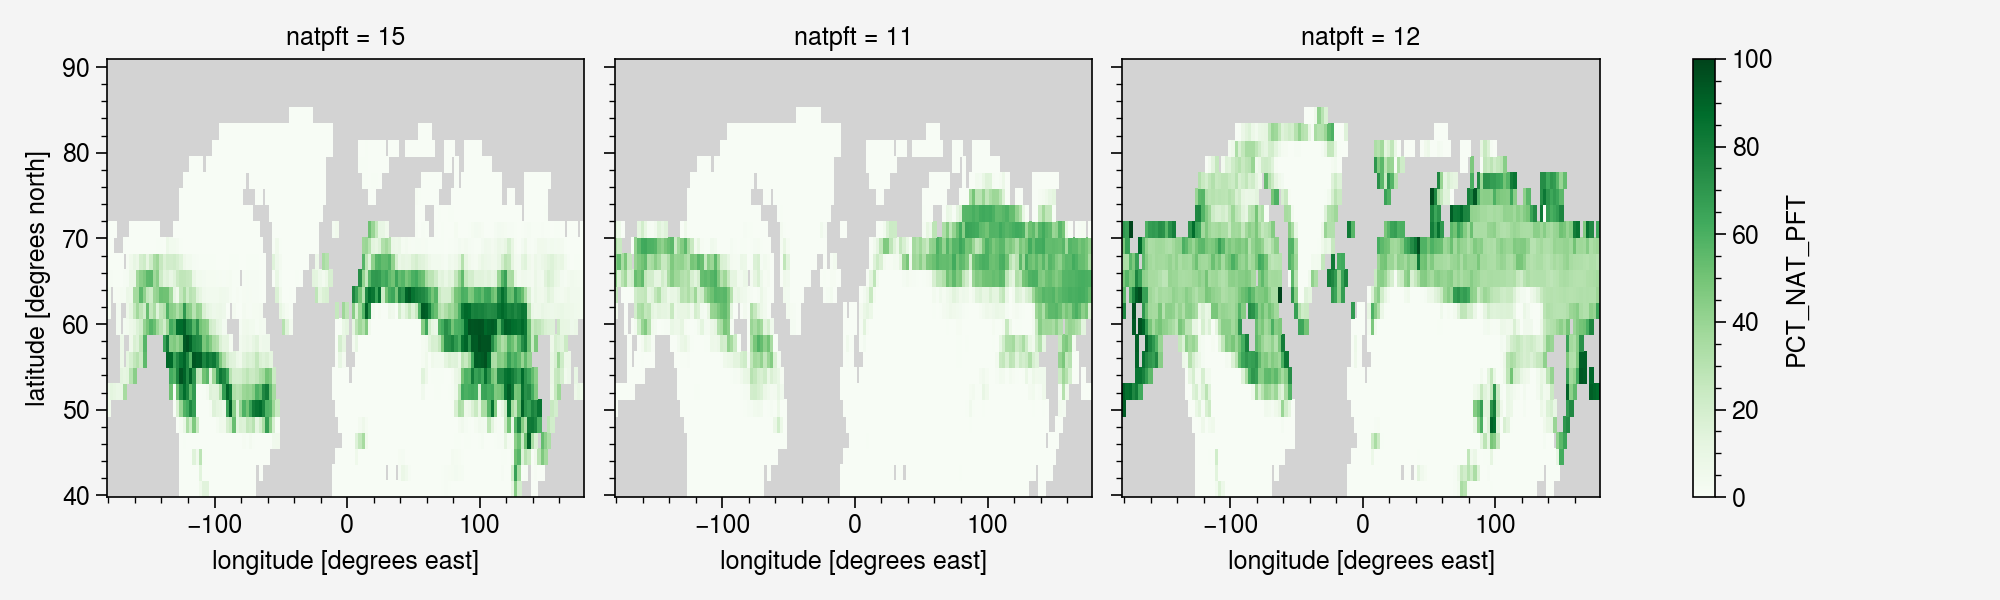

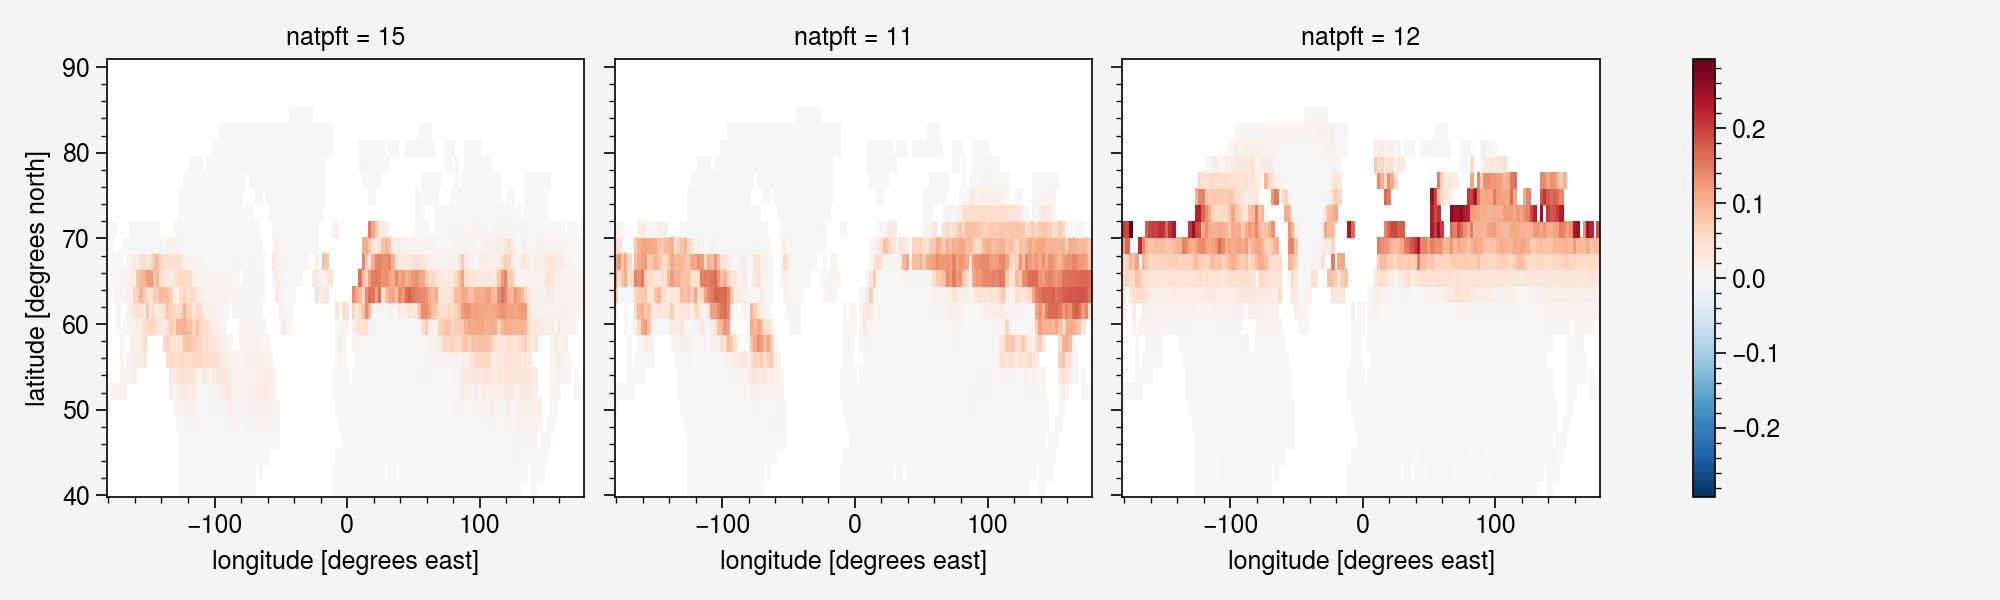

In [64]:
a = boreal_pfts_macro
a.plot(col='natpft', cmap='Greens', subplot_kws=dict(facecolor="lightgray")); plt.show()
b = replecement_perc
b.plot(col='natpft'); plt.show() #sel(natpft=[11,12])

### Difference in shrubs and grass

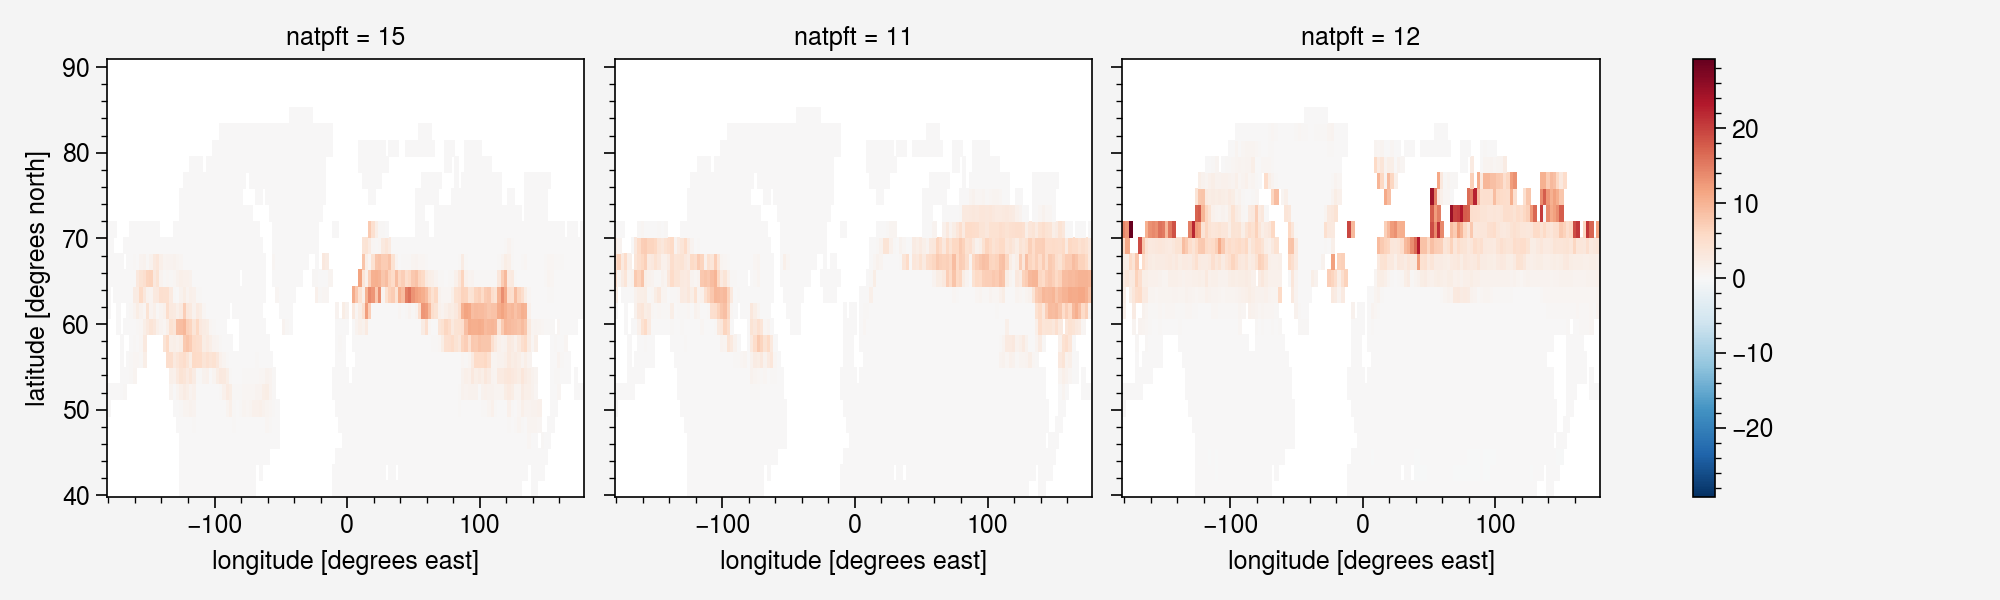

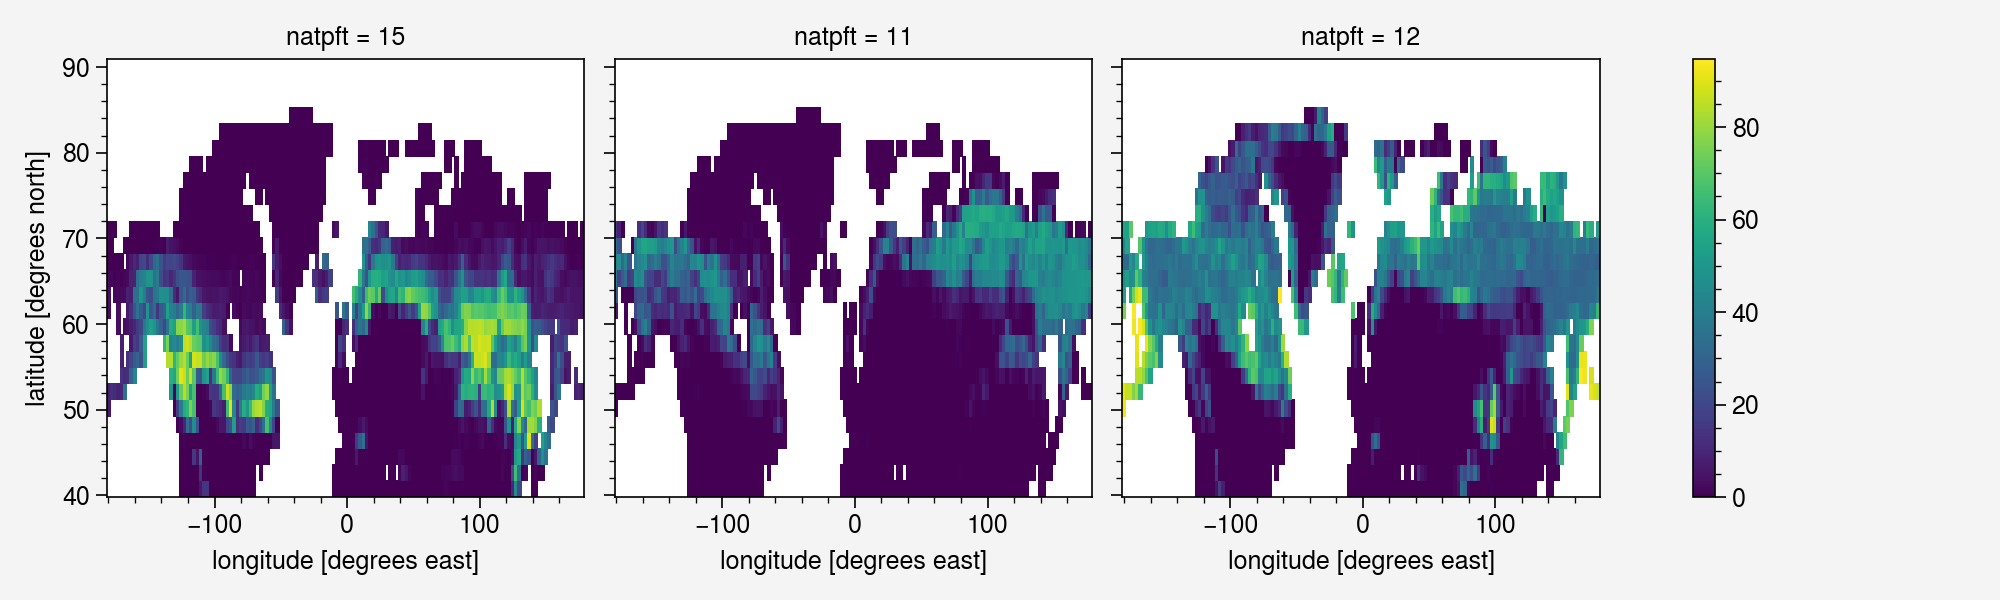

In [65]:
c=a*b
c.plot(col='natpft');plt.show()

d=a-c
d.plot(col='natpft')

In [66]:
x=a.isel(lon=100, lat=15, natpft=1).values
y=b.isel(lon=100, lat=15, natpft=1).values
z=x*y
w=c.isel(lon=100, lat=15, natpft=1).values
print(z,w)
print(x-z, d.isel(lon=100, lat=15, natpft=1).values)

6.0996009521497 6.0996009521497
51.42008360151727 51.42008360151727


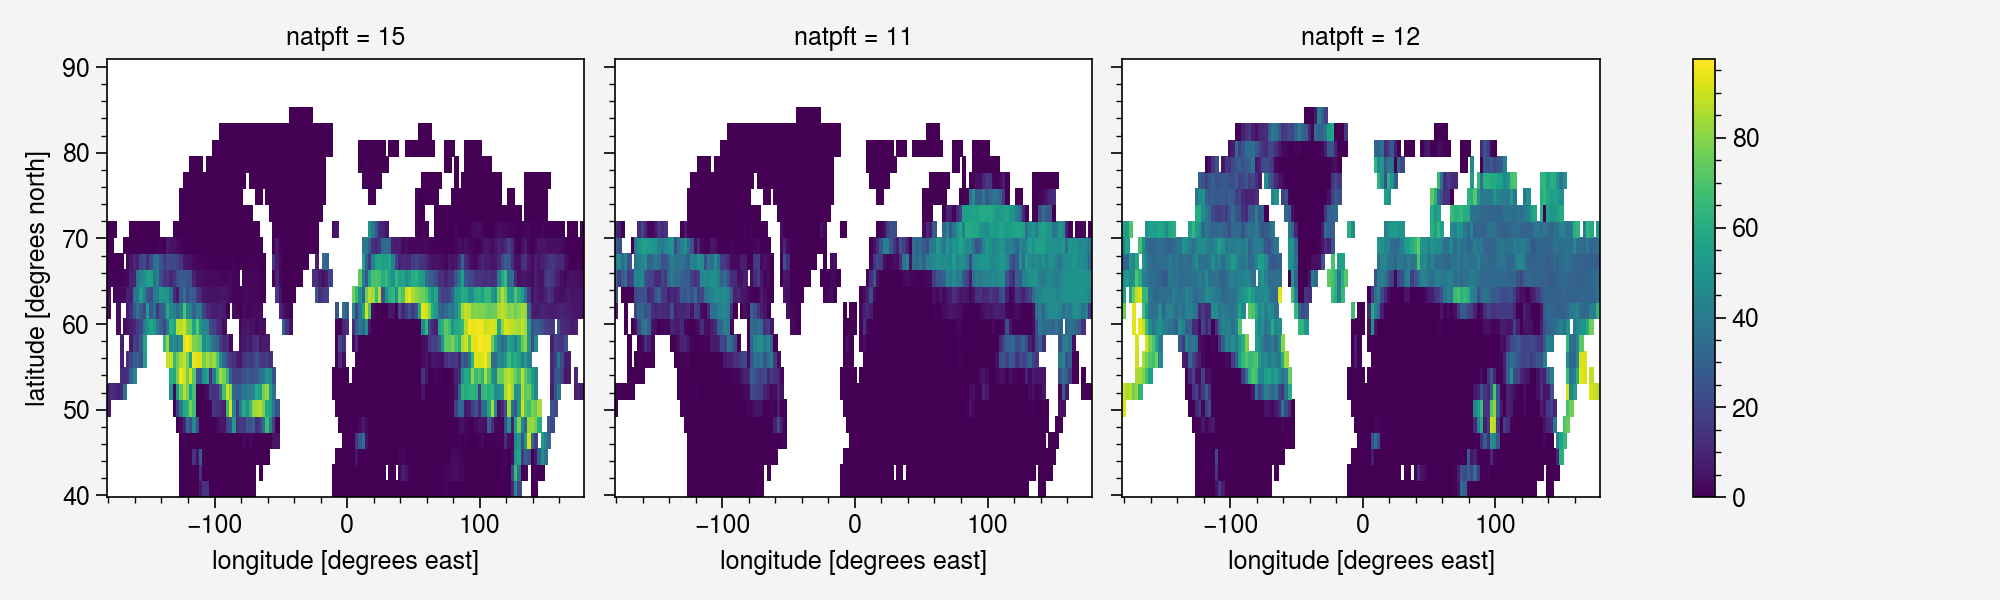

In [67]:
subtracted = d.where(d.natpft!=15, boreal_pfts_macro.sel(natpft=15))
subtracted.plot(col='natpft')

### Sum for trees and shrubs

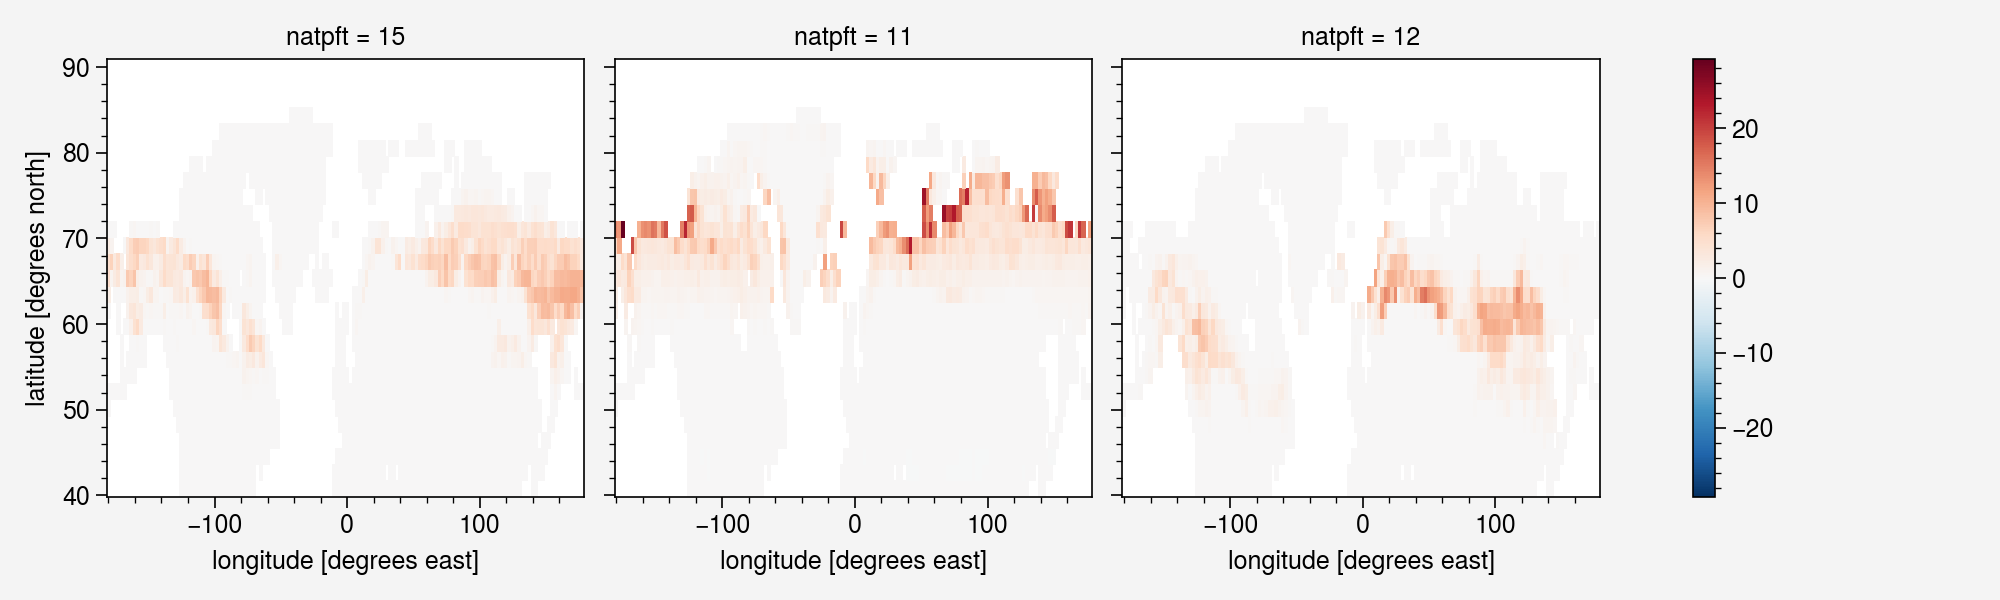

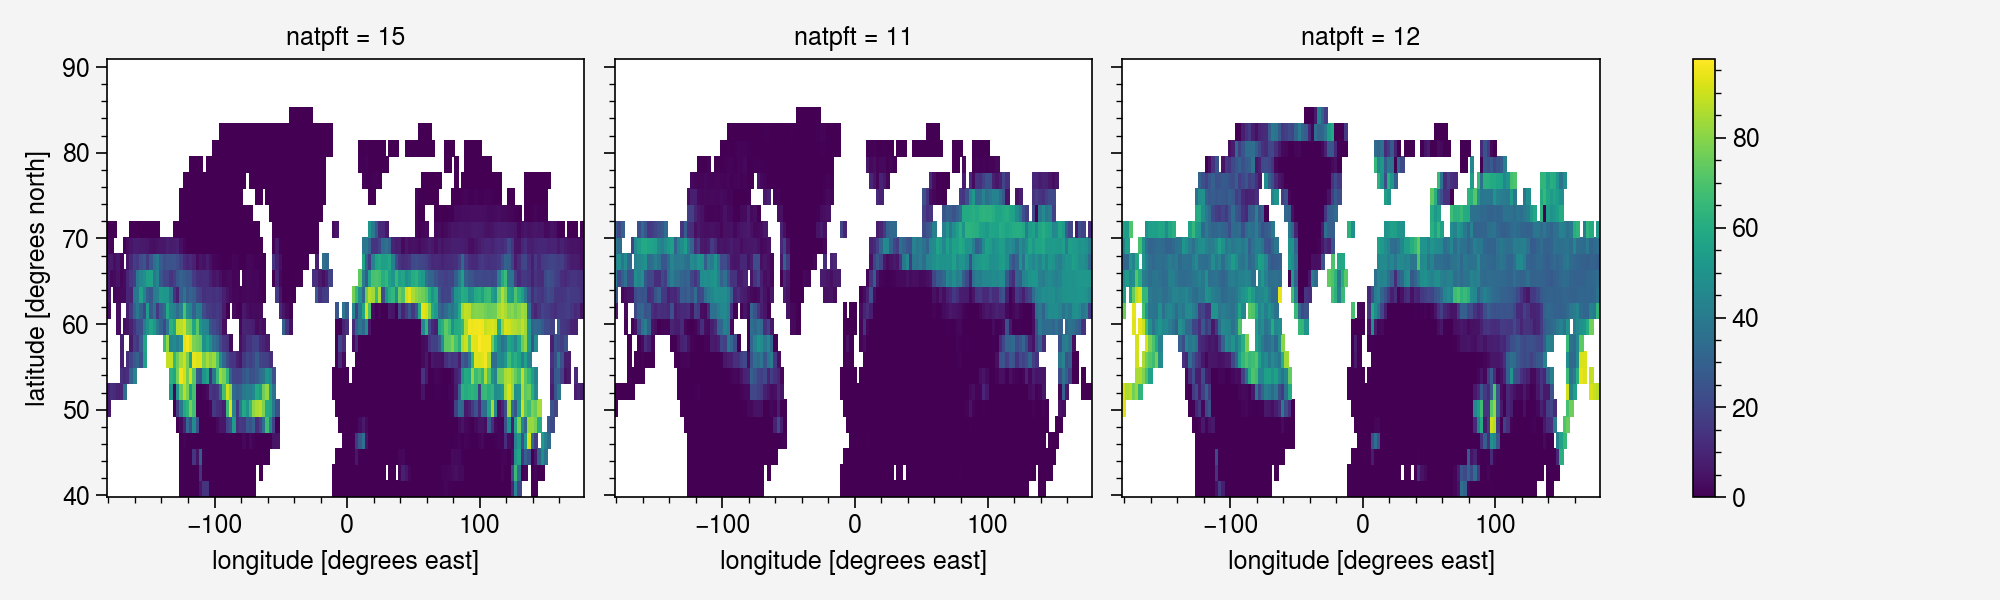

In [68]:
e = c.roll(natpft=-1)
e.plot(col='natpft'); plt.show()

f = subtracted+e
#f.where(f<0.).plot(col='natpft')
f=f.where(f>0., 0.).where(lnd_frac>0.)
f.plot(col='natpft')

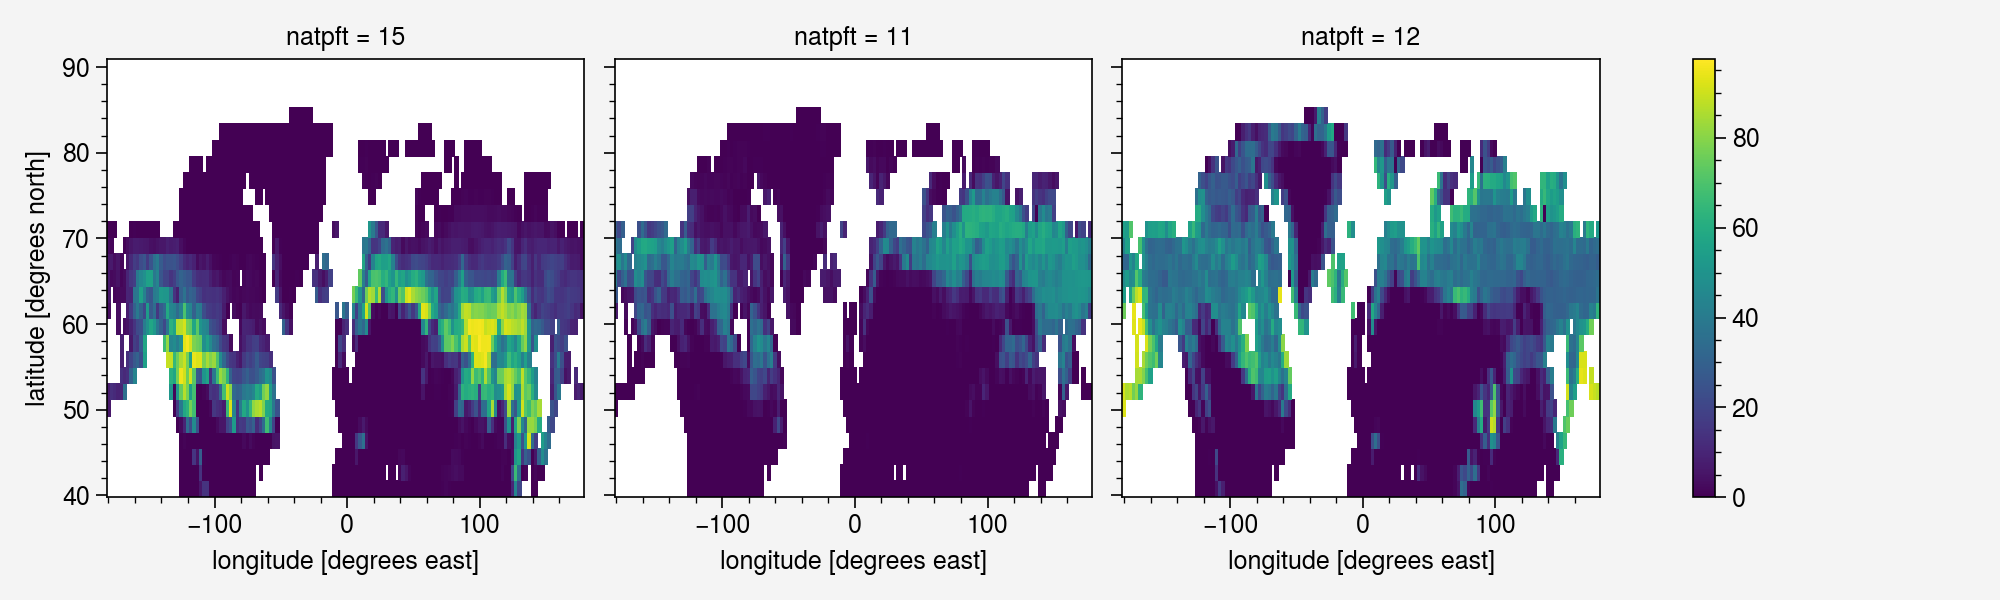

In [69]:
edited_macro = f.where(f.natpft!=12, subtracted.sel(natpft=12))
edited_macro.plot(col='natpft')

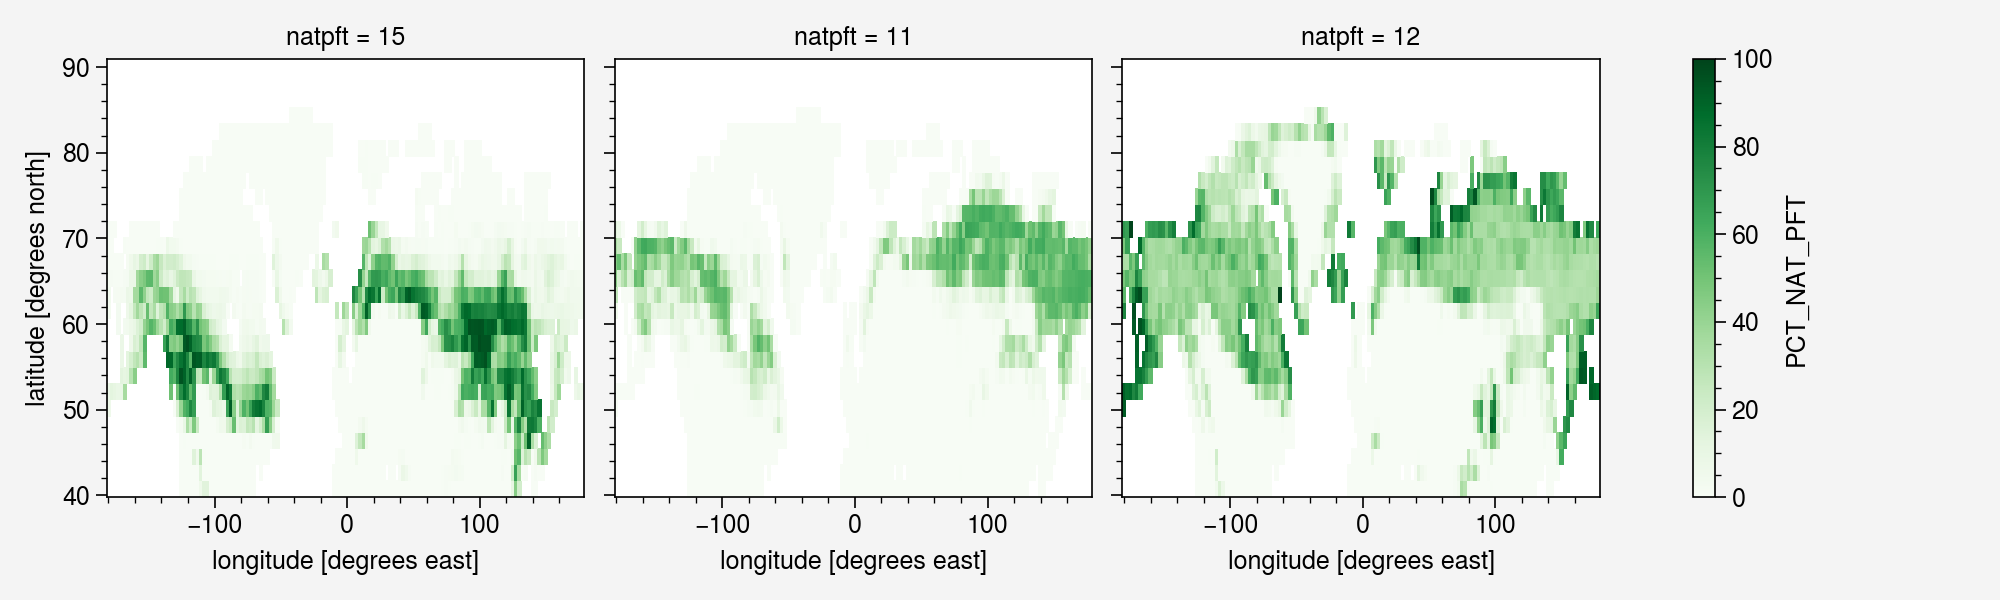

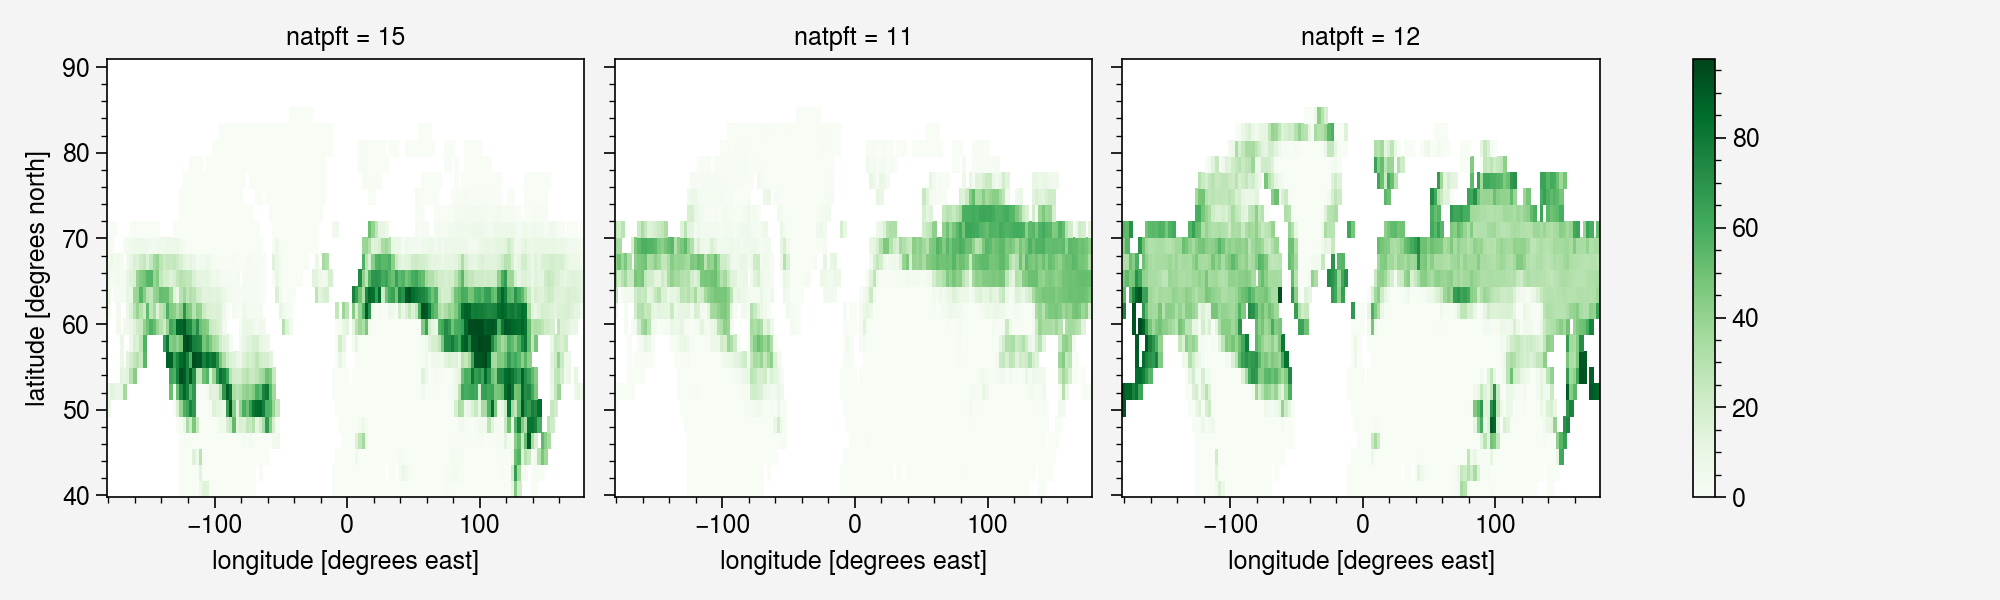

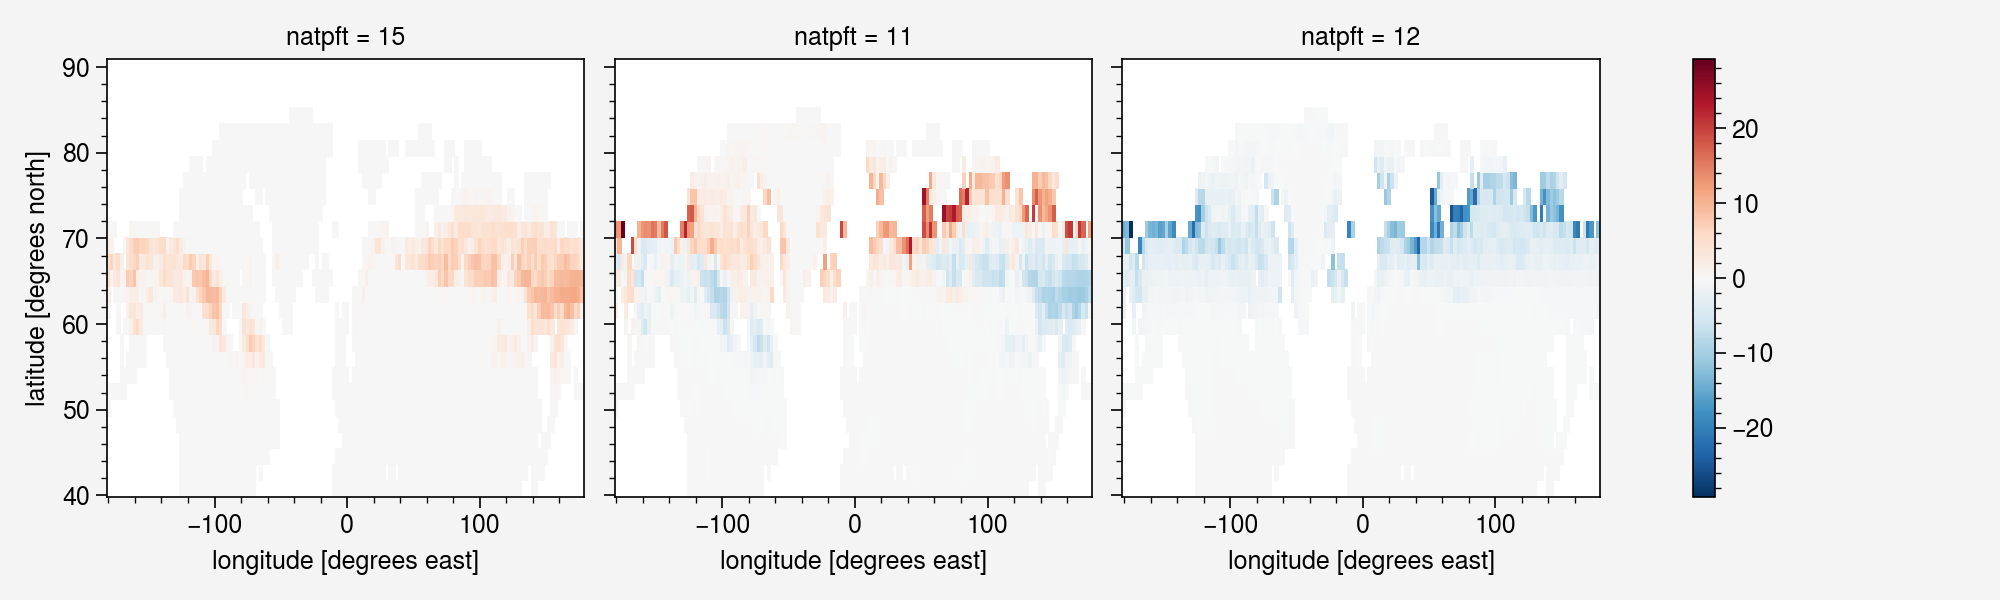

In [70]:
boreal_pfts_macro.plot(col='natpft', cmap='Greens')
edited_macro.plot(col='natpft', cmap='Greens')
(edited_macro-boreal_pfts_macro).plot(col='natpft')

### Separation within tree PFTs

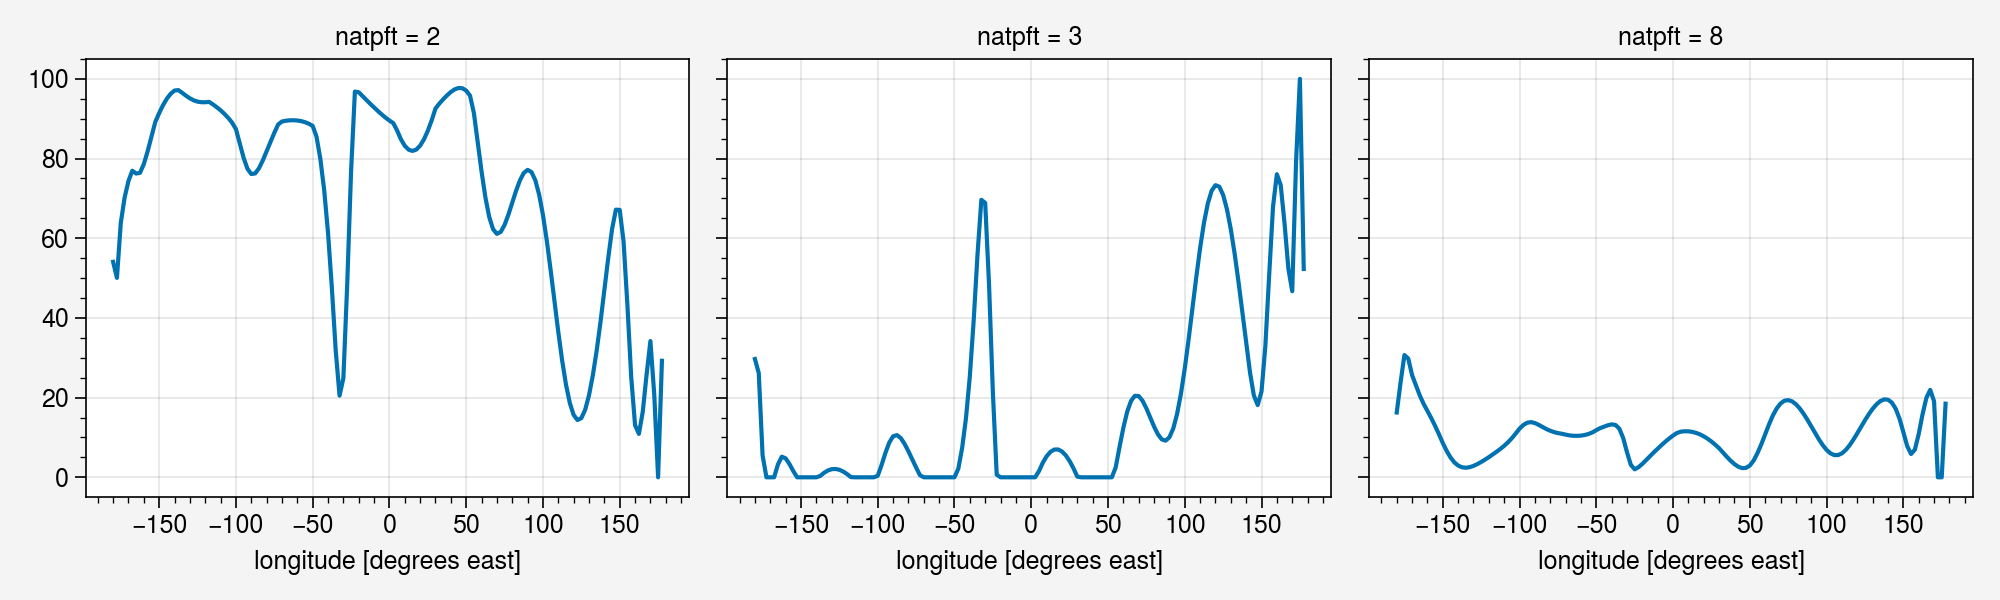

In [71]:
tree_lon_perc.plot(col='natpft')

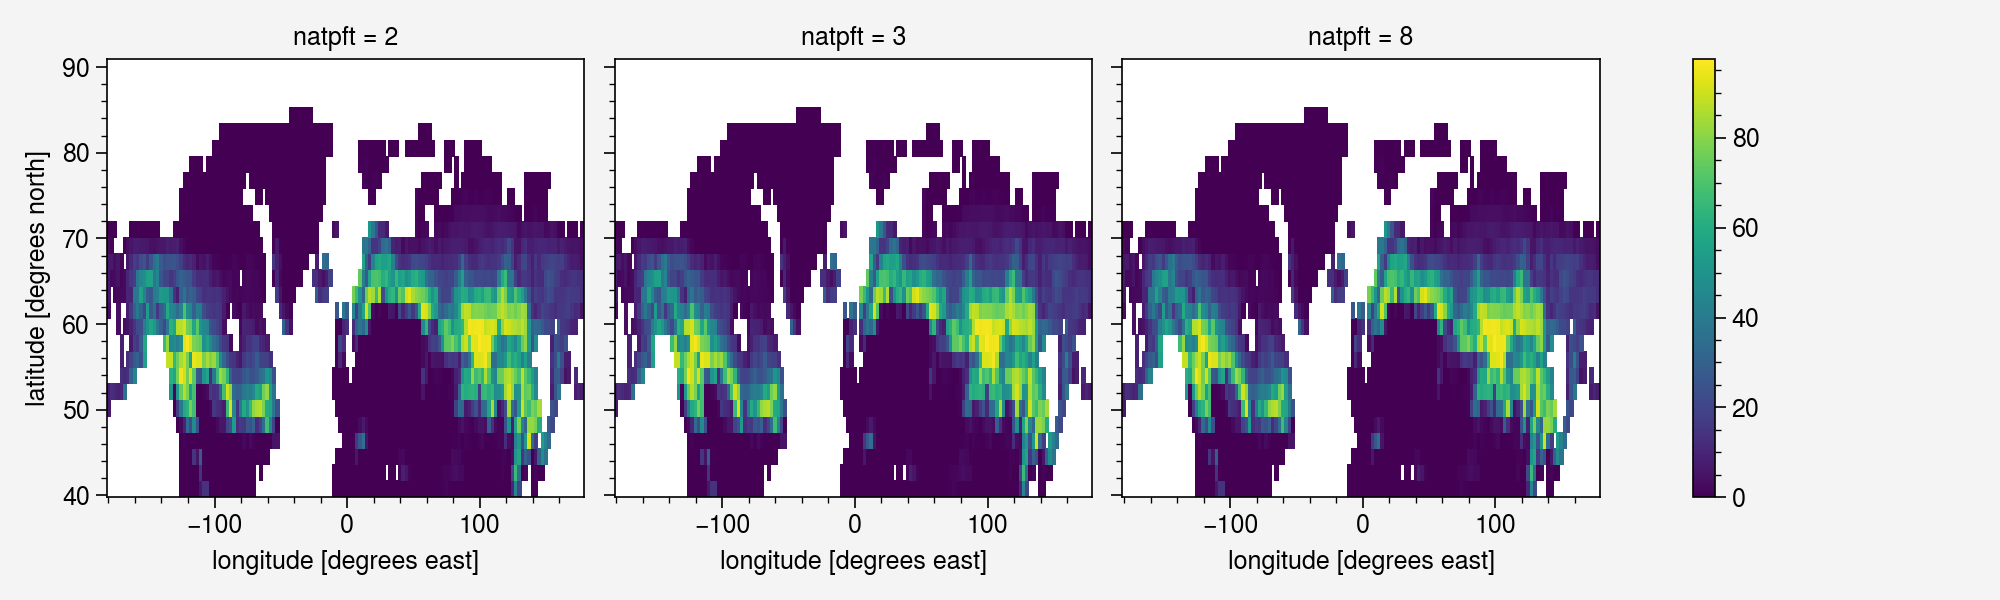

In [72]:
tree_pfts = [2,3,8]

for t in tree_pfts:
    if t == 2:
        edited_trees = edited_macro.sel(natpft=15).assign_coords({"natpft":t}).expand_dims('natpft')
    else:
        et = edited_macro.sel(natpft=15).assign_coords({"natpft":t}).expand_dims('natpft')
        edited_trees = xr.concat((edited_trees, et), dim='natpft')
                                 
edited_trees.plot(col='natpft')

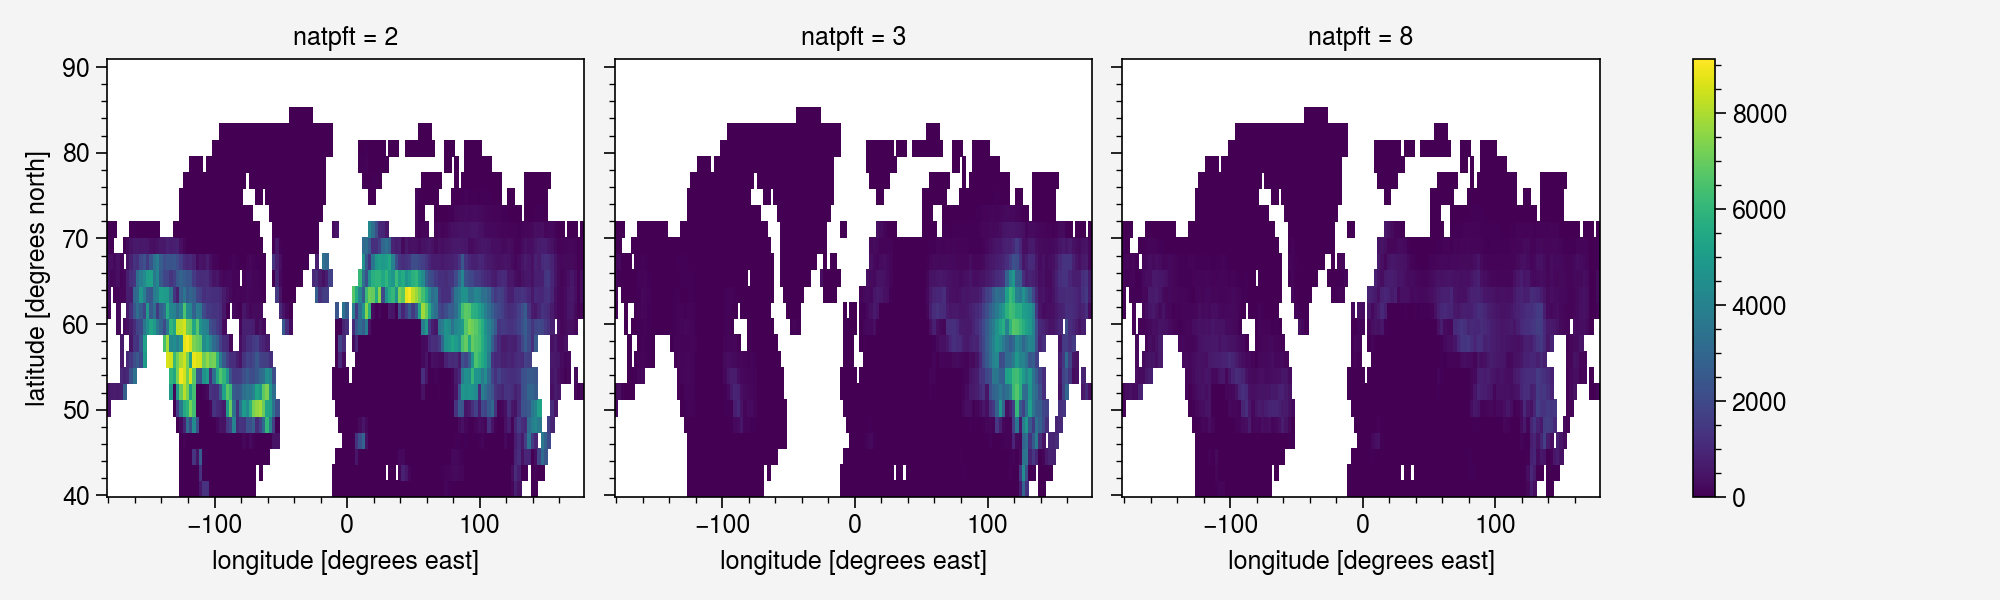

In [77]:
edited_boreal_trees = weight_da(edited_trees, 'lon', tree_lon_perc)
edited_boreal_trees.plot(col='natpft')

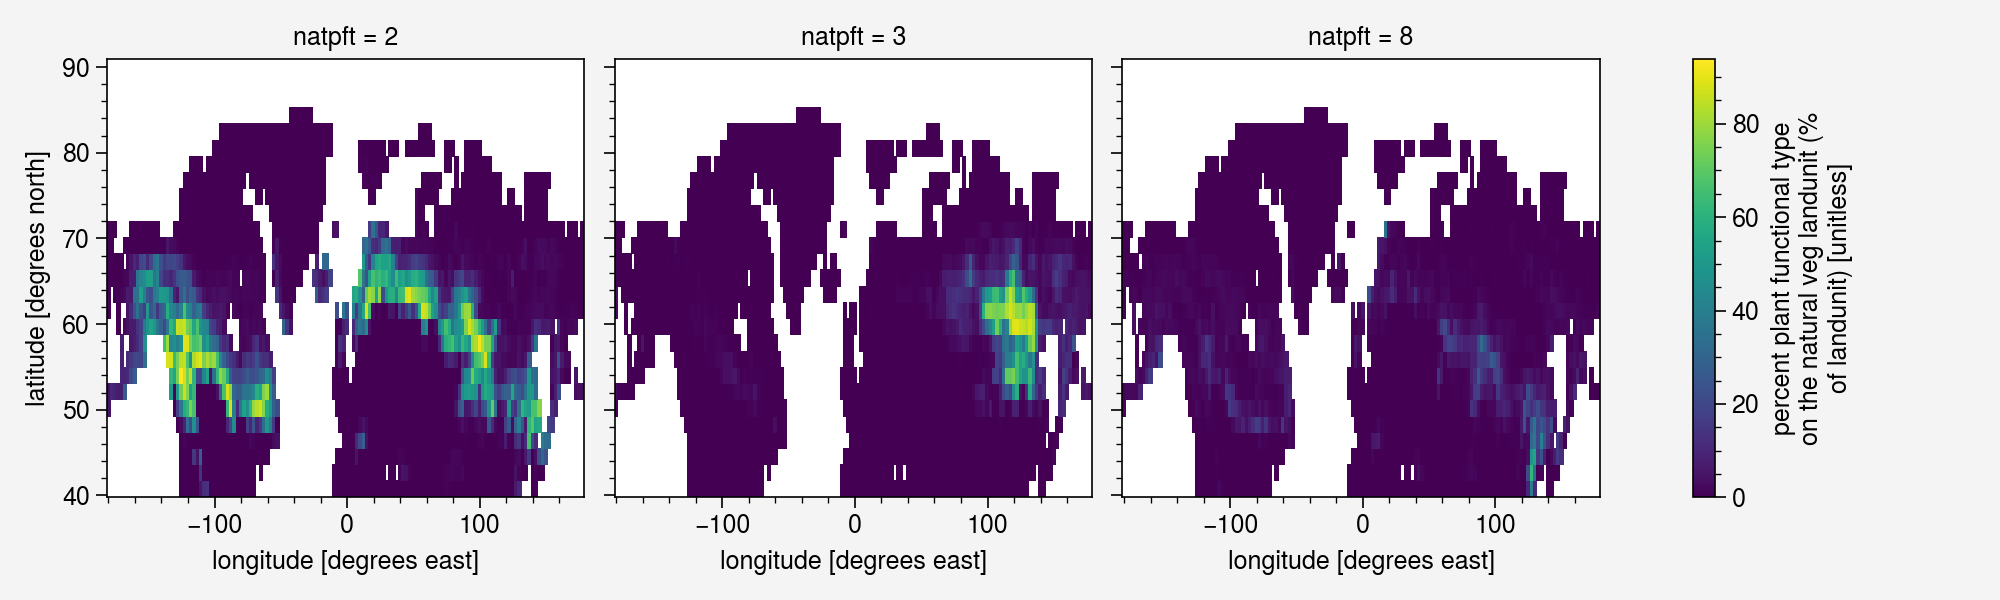

In [74]:
btrees = boreal_pfts.isel(natpft=[0,1,2])
btrees.plot(col='natpft')

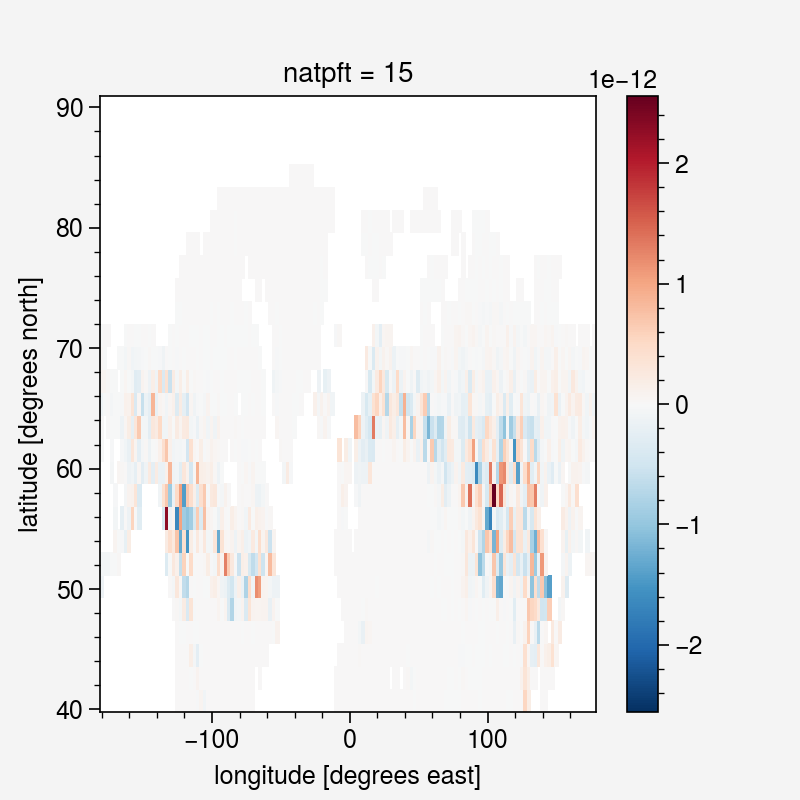

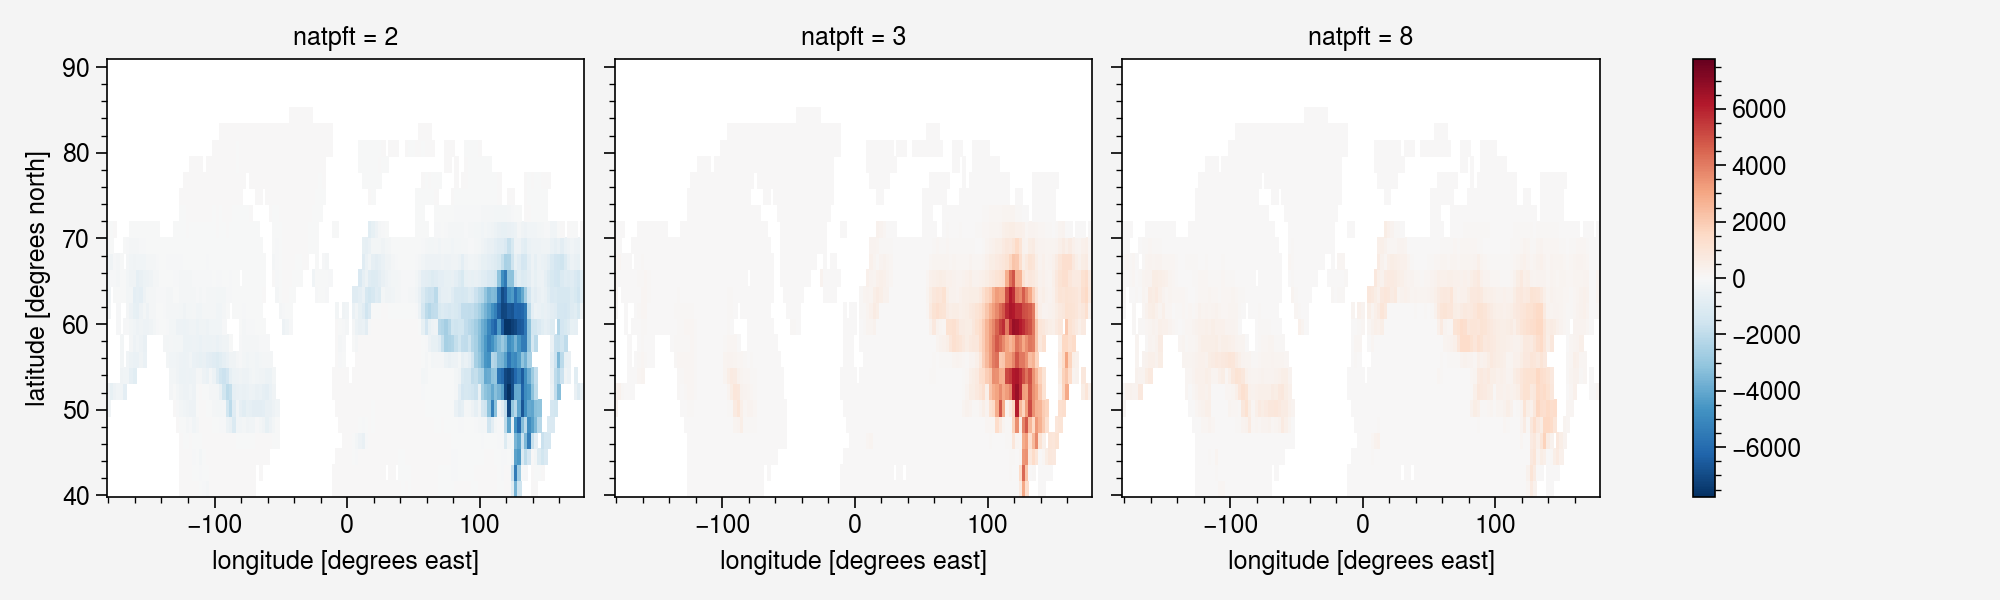

In [79]:
a = edited_macro.sel(natpft=15)
b = edited_boreal_trees.sum('natpft')#.plot(); plt.show()
errata_diff = a-b

edited_boreal_trees = edited_boreal_trees.where(edited_boreal_trees.natpft != 2, edited_boreal_trees.sel(natpft=2)+errata_diff)
edited_boreal_trees.plot(col='natpft')

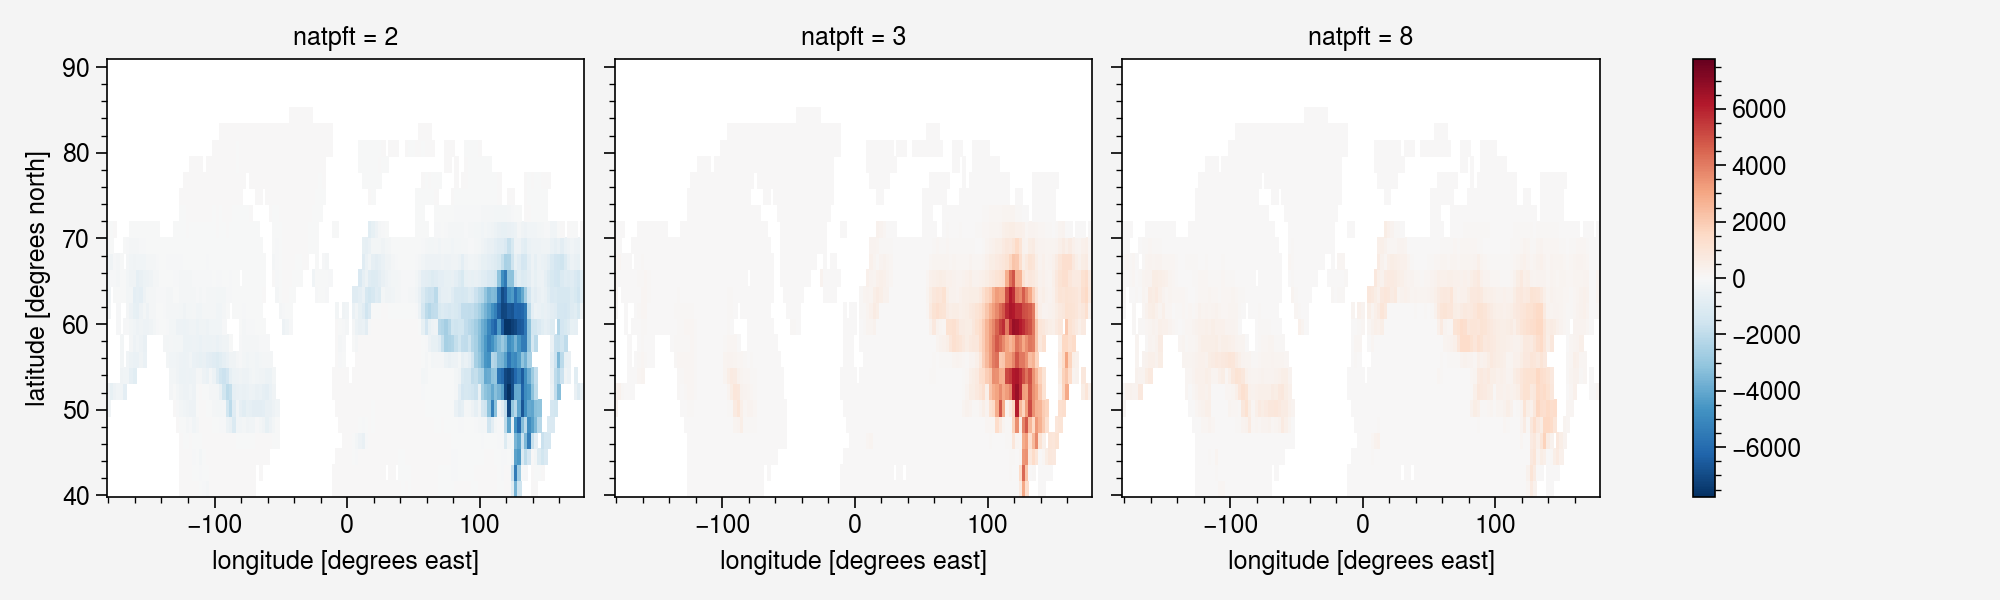

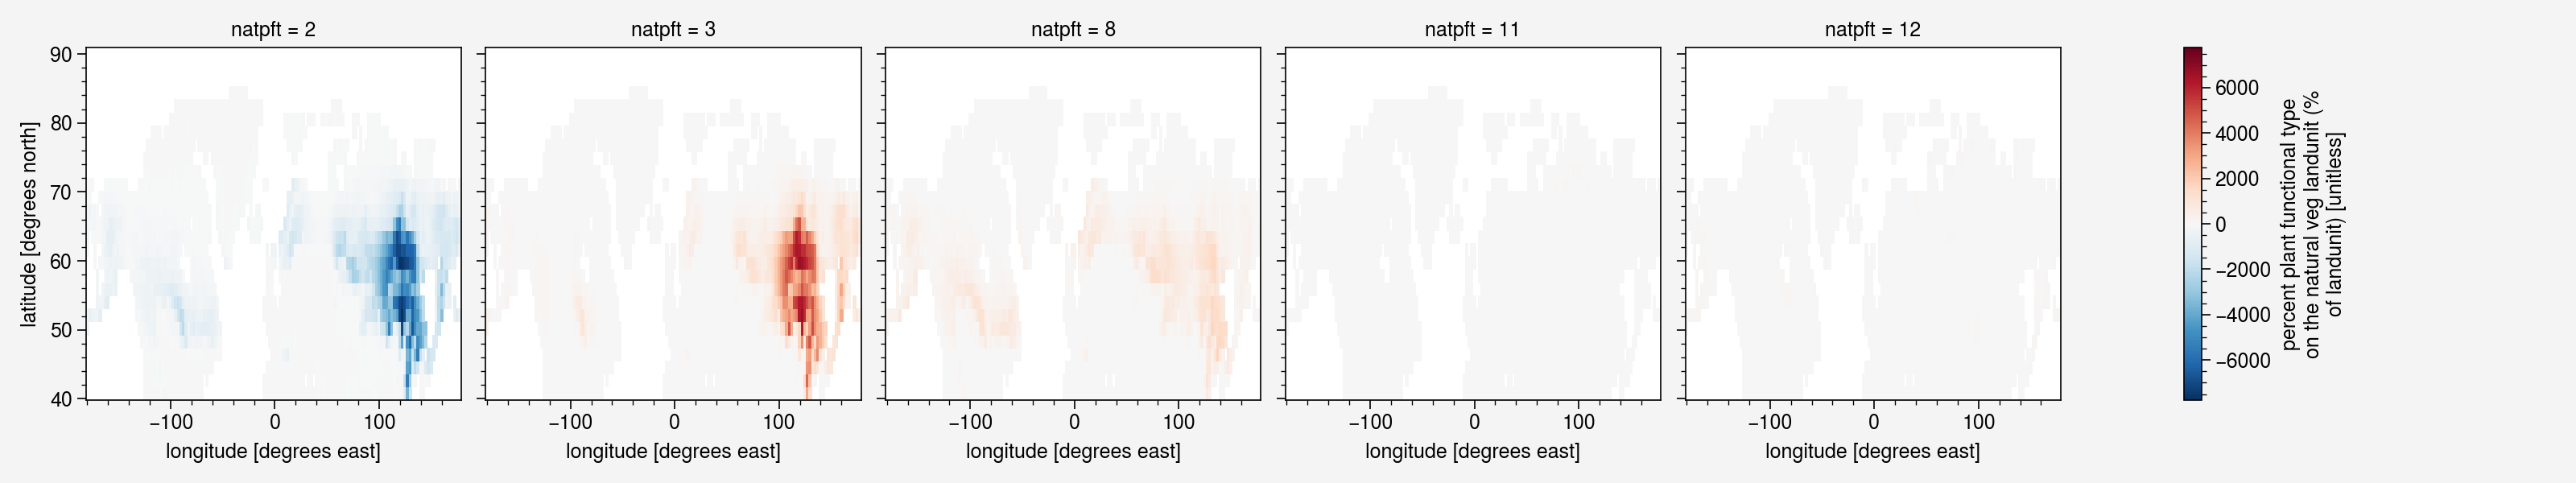

In [80]:
wow = xr.concat((edited_boreal_trees, edited_macro), dim='natpft').sel(natpft=[2,3,8,11,12])
wow = wow.assign_attrs(boreal_pfts.attrs)
wow.plot(col='natpft')

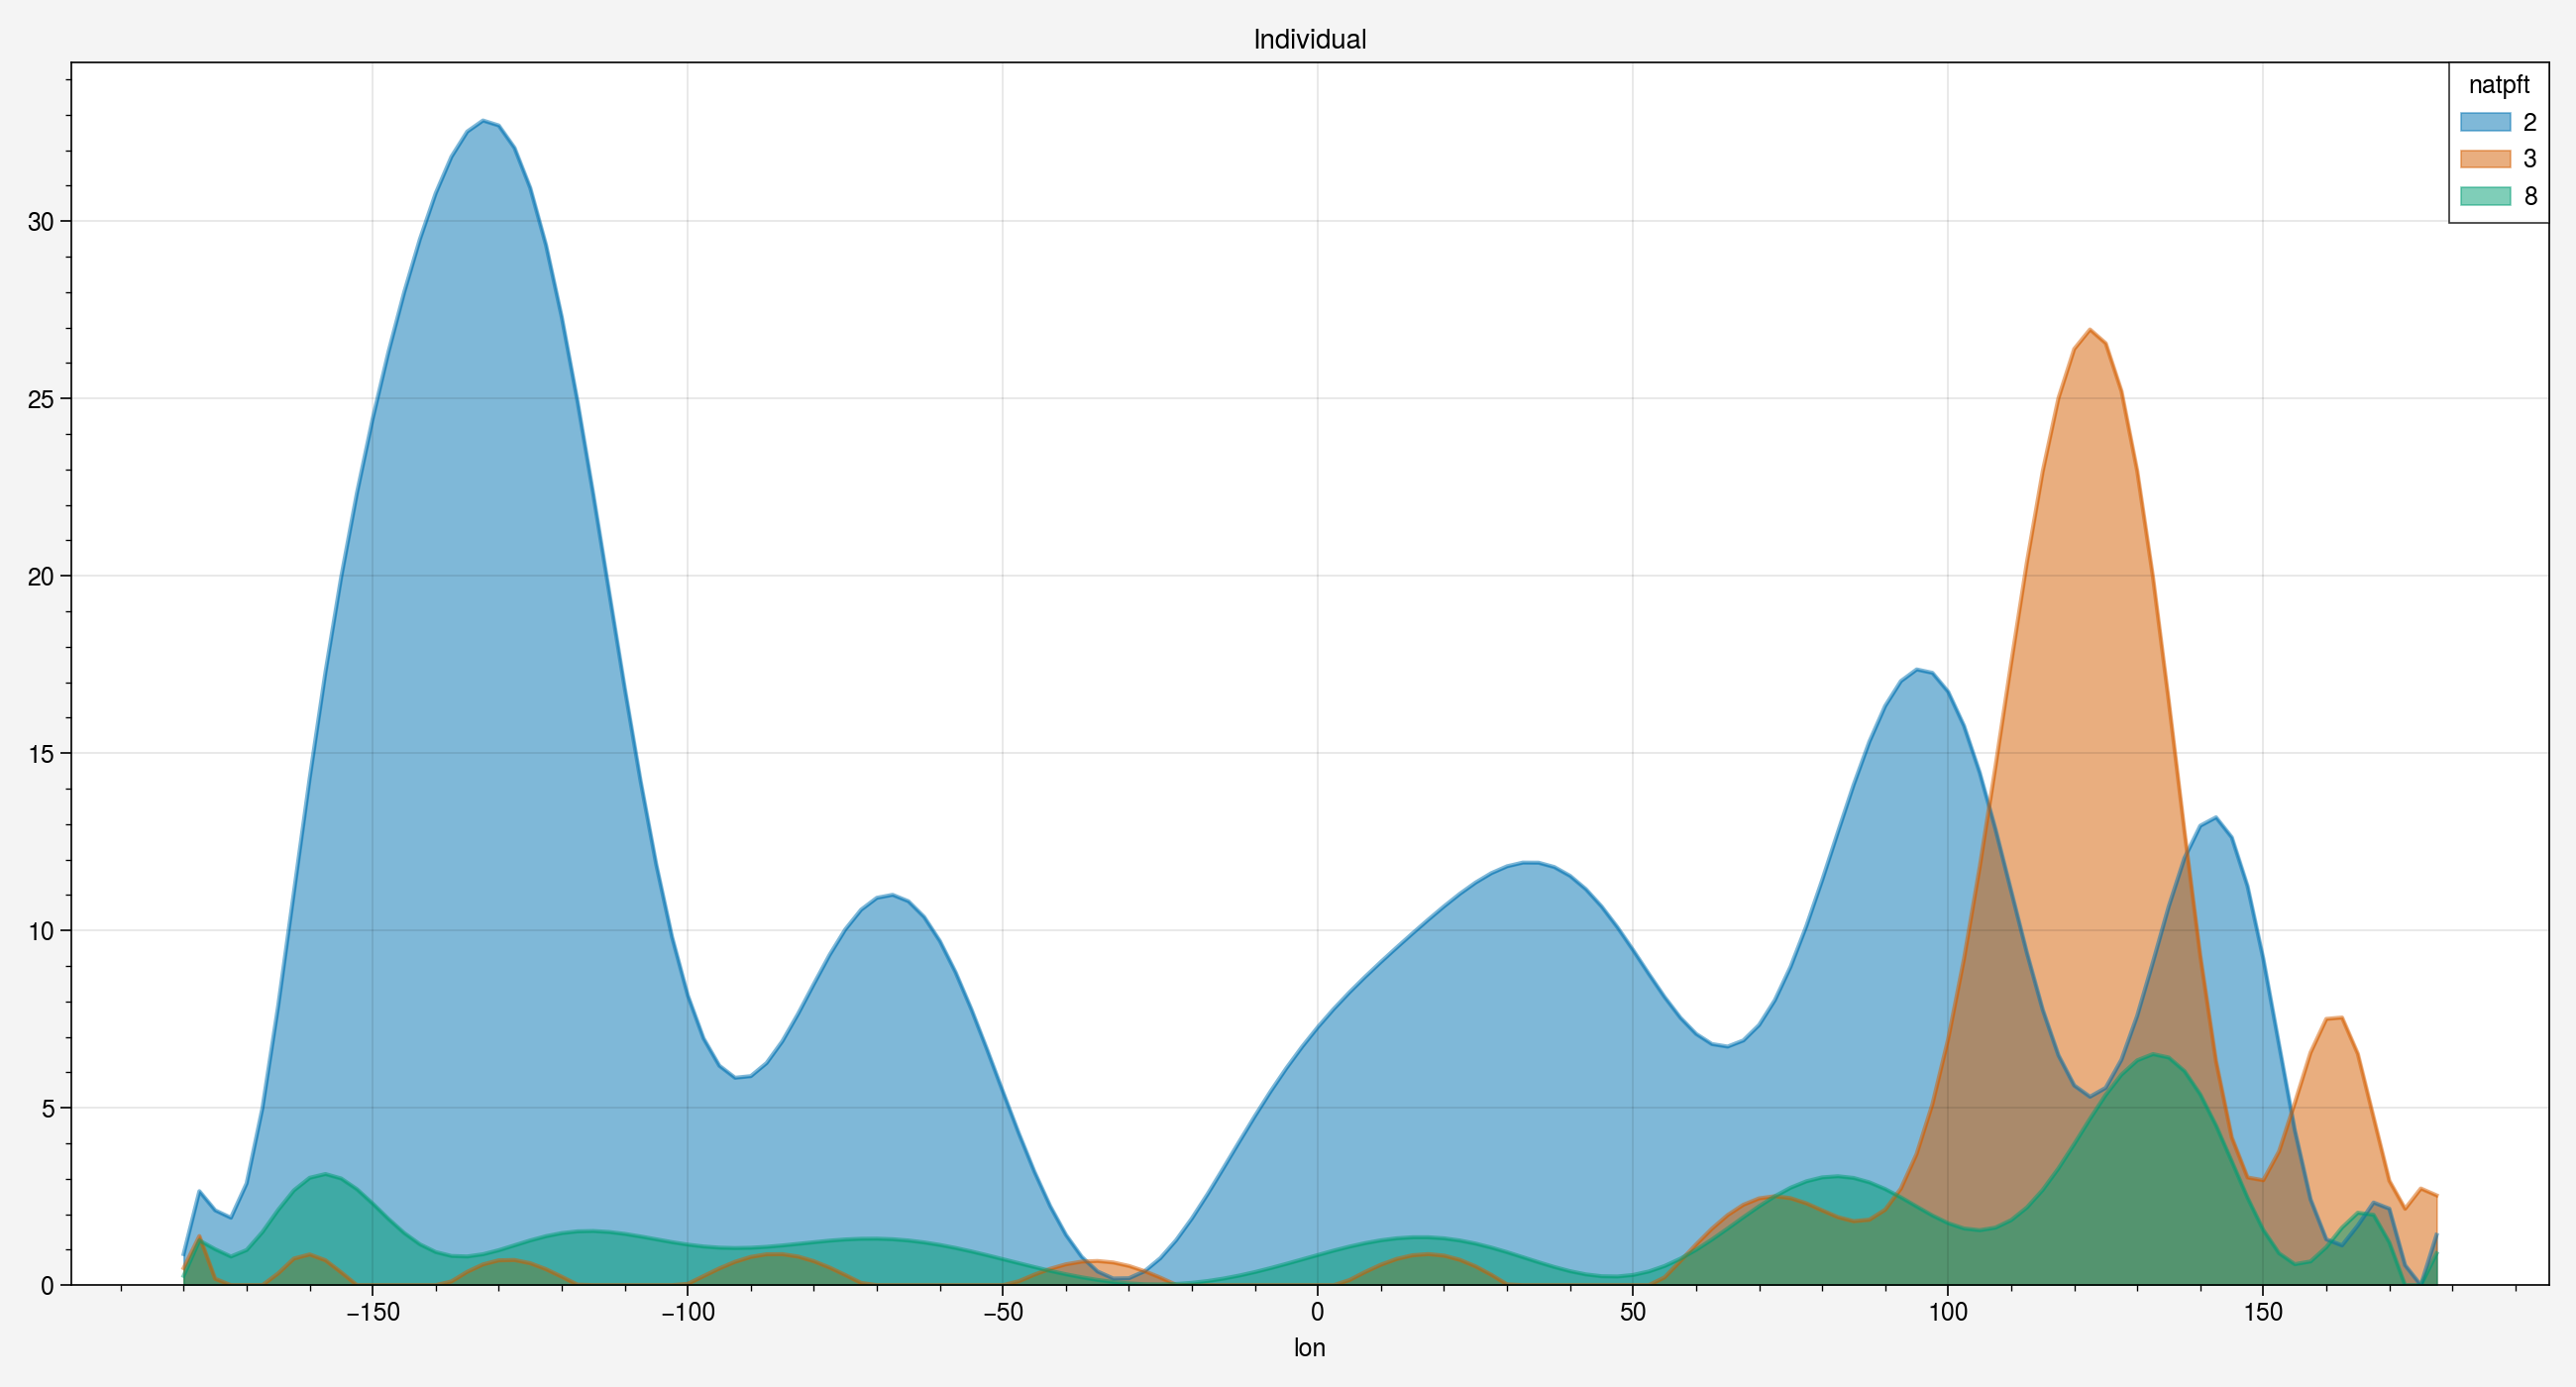

In [74]:
fig, ax = plt.subplots(figsize=(13, 7))
series = ds_lon['polyfit'].sel(natpft=[2,3,8]).T.to_series().unstack()
#series.plot.bar(ax=ax)#, stacked=True)
series.plot.area(ax=ax, stacked=False, title="Individual")
plt.tight_layout()
plt.show()

In [ ]:
def gaussian(x, A, xc, sig):
    return A*np.exp(-np.power((x - xc),2.) / (2 * np.power(sig,2.)))

ds = pfts_b_mask.copy()
ds_lat=ds.mean('lon').dropna(dim='lat')#fillna(0.)
ds_lat.plot(y='lat', col='natpft', col_wrap=3); plt.show()

#All tests
ds_mean.sel(natpft=2).plot()
#display(list(ds_mean.sel(natpft=2).values))
#display(ds_mean.sel(natpft=2).lat.values)
#plt.show()

from scipy.optimize import curve_fit
xdata = list(ds_mean.sel(natpft=2).lat.values)
ydata = list(ds_mean.sel(natpft=2).values)
p0=[45,55,5]
#plt.plot(xdata,ydata)
popt, pcov = curve_fit(gaussian, xdata, ydata,p0=p0)
#print(pcov)
#plt.plot(xdata, func(xdata, *popt), 'r-')#, label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
#plt.show()


fitted=ds_mean.curvefit(coords='lat', func=gaussian, p0={'A':45, 'xc':55, 'sig':5})
#display(fitted)
popt=fitted.curvefit_coefficients # NO! .values
gaussian(ds_mean.lat, *popt.T).drop('param').plot(y='lat',col='natpft', col_wrap=3)

In [23]:
xr.apply_ufunc(gaussian, ds_mean, *fitted2.curvefit_coefficients.values)#, input_core_dims=[["lat"], ["lat"]])#, exclude_dims=set['natpft'])

NameError: name 'ds_mean' is not defined

In [ ]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def gaussian_2d(coords, a, xc, yc, xalpha, yalpha):
   ....:     x, y = coords
   ....:     z = a * np.exp(
   ....:         -np.square(x - xc) / 2 / np.square(xalpha)
   ....:         - np.square(y - yc) / 2 / np.square(yalpha)
   ....:     )
   ....:     return z

.curvefit(coords=("lat"), func=plane)

In [ ]:
ds = pfts_b_mask.copy()
ds = ds.mean('lon')
#ds.plot(y='lat', col ='natpft', col_wrap=3)
out = ds.polyfit(dim="lat", deg=3, full=True)
fitted = xr.polyval(ds.lat, out.polyfit_coefficients)
fitted

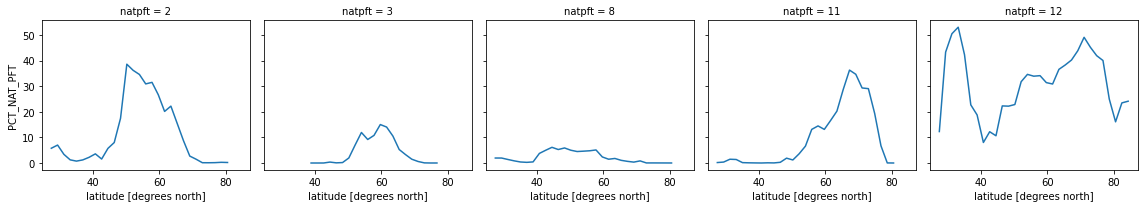

<xarray.DataArray 'PCT_NAT_PFT' (lat: 96)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  5.76029972,  7.00752772,  3.38604397,
        1.23237214,  0.74271816,  1.20971883,  2.22238579,  3.57472306,
        1.55261772,  5.71164692,  7.995994  , 17.46430736, 38.57395899,
       36.18572311, 34.56836717, 30.88280151, 31.48585954, 26.63632882,
       20.13994601, 22.20788426, 15.46833746,  8.7211972 ,  2.70969236,
        1.48915088,  0.11481746,  0.10446532,  0.14308866,  0.27134593,
        0.20548004,         nan,         nan,         nan,         nan,
               nan])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0

<xarray.Dataset>
Dimensions:               (degree: 4)
Coordinates:
  * degree                (degree) int64 3 2 1 0
Data variables:
    polyfit_coefficients  (degree) float64 -0.0008449 0.09717 -2.711 17.35

array([-8.44923996e-04,  9.71714908e-02, -2.71059435e+00,  1.73457567e+01])

<xarray.DataArray (lat: 96)>
array([ 1.66433792e+03,  1.58832147e+03,  1.51460623e+03,  1.44315769e+03,
        1.37394138e+03,  1.30692281e+03,  1.24206751e+03,  1.17934098e+03,
        1.11870874e+03,  1.06013631e+03,  1.00358921e+03,  9.49032943e+02,
        8.96433036e+02,  8.45755001e+02,  7.96964356e+02,  7.50026616e+02,
        7.04907297e+02,  6.61571916e+02,  6.19985988e+02,  5.80115031e+02,
        5.41924559e+02,  5.05380090e+02,  4.70447139e+02,  4.37091223e+02,
        4.05277857e+02,  3.74972559e+02,  3.46140843e+02,  3.18748226e+02,
        2.92760225e+02,  2.68142356e+02,  2.44860134e+02,  2.22879076e+02,
        2.02164698e+02,  1.82682516e+02,  1.64398046e+02,  1.47276805e+02,
        1.31284309e+02,  1.16386073e+02,  1.02547615e+02,  8.97344493e+01,
        7.79120932e+01,  6.70460626e+01,  5.71018735e+01,  4.80450423e+01,
        3.98410851e+01,  3.24555179e+01,  2.58538571e+01,  2.00016186e+01,
        1.48643188e+01,  1.04074738e+01,  6.59659969e+00,  3.39721267e+00,
        7.74828910e-01, -1.30503544e+00, -2.87686420e+00, -3.97514123e+00,
       -4.63435035e+00, -4.88897541e+00, -4.77350024e+00, -4.32240868e+00,
       -3.57018457e+00, -2.55131174e+00, -1.30027404e+00,  1.48444705e-01,
        1.76036065e+00,  3.50098995e+00,  5.33584878e+00,  7.23045330e+00,
        9.15031966e+00,  1.10609640e+01,  1.29279026e+01,  1.47166515e+01,
        1.63927269e+01,  1.79216449e+01,  1.92689218e+01,  2.04000736e+01,
        2.12806166e+01,  2.18760669e+01,  2.21519407e+01,  2.20737541e+01,
        2.16070233e+01,  2.07172645e+01,  1.93699938e+01,  1.75307273e+01,
        1.51649813e+01,  1.22382719e+01,  8.71611531e+00,  4.56402762e+00,
       -2.52474975e-01, -5.76787632e+00, -1.20166602e+01, -1.90333106e+01,
       -2.68523112e+01, -3.55081459e+01, -4.50352985e+01, -5.54682530e+01])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0

LinAlgError: SVD did not converge in Linear Least Squares

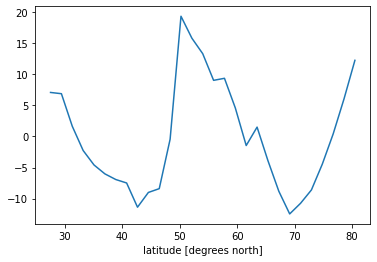

In [129]:
ds = pfts_b_mask.copy()
ds = ds.mean('lon')
ds.plot(col='natpft')
plt.show()
ds = ds.sel(natpft=2)
ds = ds.drop_vars('natpft')
display(ds)
out = ds.polyfit(dim='lat',deg=3)
display(out)
display(np.transpose(out.polyfit_coefficients.values))
a = xr.polyval(ds['lat'],out.polyfit_coefficients)
display(a)
b= ds-a
b.plot()

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    ds=da.copy()
    ds=ds.fillna
    p = da.polyfit(dim=dim, deg=deg, skipna=False)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

detrend_dim(ds,'lat',3)

In [59]:
# Example data
da = xr.DataArray(np.random.randn(20, 180, 360),
                  dims=('time', 'lat', 'lon'),
                  coords={'time': np.linspace(0,19, 20), 
                  'lat': np.linspace(-90,90,180), 
                  'lon': np.linspace(0,359, 360)})

# define a function to compute a linear trend of a timeseries
def linear_trend(x):
    pf = np.polyfit(x.time, x, 1)
    # need to return an xr.DataArray for groupby
    return xr.DataArray(pf[0])

# stack lat and lon into a single dimension called allpoints
stacked = da.stack(allpoints=['lat','lon'])
# apply the function over allpoints to calculate the trend at each point
trend = stacked.groupby('allpoints').apply(linear_trend)
# unstack back to lat lon coordinates
trend_unstacked = trend.unstack('allpoints')

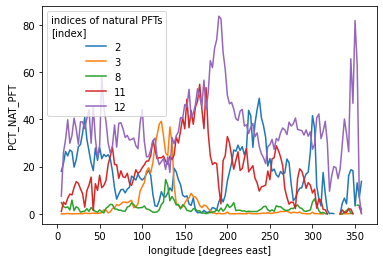

In [200]:
pfts_b_mask.where(pfts_b_mask>0.).mean('lat').plot.line(x='lon')

## Notes on what I learnt

### Surface

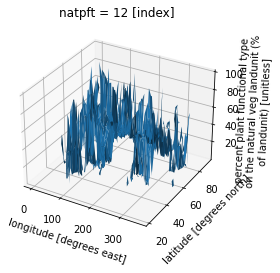

In [19]:
pfts_b_mask.sel(natpft=12).where(pfts_b_mask.lat>20, drop=True).plot.surface()

In [90]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import xarray as xr

# Read the data
url = 'https://github.com/mapbox/rasterio/raw/master/tests/data/RGB.byte.tif'
da = xr.open_rasterio(url)

# The data is in UTM projection. We have to set it manually until
# https://github.com/SciTools/cartopy/issues/813 is implemented
crs = ccrs.UTM('18N')

# Plot on a map
ax = plt.subplot(projection=crs)
da.plot.imshow(ax=ax, rgb='band', transform=crs)
ax.coastlines('10m', color='r')
plt.show()

ModuleNotFoundError: No module named 'rasterio'

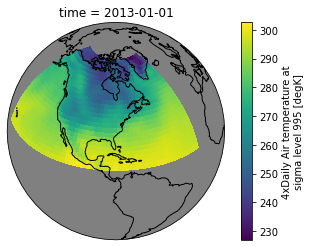

In [12]:
import cartopy.crs as ccrs

air = xr.tutorial.open_dataset("air_temperature").air

p = air.isel(time=0).plot(subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),transform=ccrs.PlateCarree(),)
p.axes.set_global()
p.axes.coastlines()